# Baseline and model pipelines

In [ ]:
blob_container = "" # The name of your container created in https://portal.azure.com
storage_account = "" # The name of your Storage account created in https://portal.azure.com
secret_scope = "" # The name of the scope created in your local computer using the Databricks CLI
secret_key = "" # The name of the secret key created in your local computer using the Databricks CLI 
blob_url = f"wasbs://{blob_container}@{storage_account}.blob.core.windows.net"
mount_path = "/mnt/mids-w261"

spark.conf.set(
  f"fs.azure.sas.{blob_container}.{storage_account}.blob.core.windows.net",
  dbutils.secrets.get(scope = secret_scope, key = secret_key)
)

data_BASE_DIR = "dbfs:/mnt/mids-w261/datasets_final_project_2022/"

## Imports

In [ ]:
import pandas as pd
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import random
import itertools
from datetime import datetime

# Basic Functions
from pyspark.sql import functions as f
from pyspark.sql import SQLContext
from pyspark.sql.functions import monotonically_increasing_id
from pyspark.sql.functions import isnan, when, count, col, isnull, percent_rank
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, IntegerType, NullType, ShortType, DateType, BooleanType, BinaryType, FloatType
 
# For feature engineering
from pyspark.ml.feature import StandardScaler, MinMaxScaler, VectorAssembler, VectorIndexer, StringIndexer, OneHotEncoder, ChiSqSelector, Bucketizer, Imputer
from pyspark.ml import Pipeline
from pyspark.ml.linalg import Vectors
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.window import Window
from pyspark.streaming import StreamingContext
from pyspark.sql import Row
from functools import reduce
from pyspark.sql.functions import rand,col,when,concat,substring,lit,udf,lower,sum as ps_sum,count as ps_count,row_number
from pyspark.sql.window import *
from pyspark.sql import DataFrame
from pyspark.ml.feature import VectorAssembler,BucketedRandomProjectionLSH,VectorSlicer
from pyspark.ml.linalg import Vectors,VectorUDT
from pyspark.sql.functions import array, create_map, struct
 
# For Modeling
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, LinearSVC, RandomForestClassifier, GBTClassifier, MultilayerPerceptronClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline
from pyspark.ml.linalg import Vectors
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics, MulticlassMetrics
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve, plot_roc_curve

# Experimentation Tracking and Hyperparamterization
import mlflow
from  mlflow.tracking import MlflowClient
from hyperopt import fmin, tpe, hp, SparkTrials, Trials, STATUS_OK
from hyperopt.pyll import scope
import shap

"is" with a literal. Did you mean "=="?
"is" with a literal. Did you mean "=="?
"is" with a literal. Did you mean "=="?
"is" with a literal. Did you mean "=="?
"is not" with a literal. Did you mean "!="?
"is not" with a literal. Did you mean "!="?


# Model Pipeline (RUN ALL)

## General Functions

In [ ]:
def read_clean(parquet_string): 
    dataset = spark.read.parquet(f"{blob_url}/{parquet_string}")

    dataset = dataset.where("DEP_DEL15 is not NULL")

    dataset = dataset.withColumn("PREV_DEP_DELAY", col("PREV_DEP_DELAY").cast('int'))

    dataset= dataset.withColumnRenamed("DEP_DEL15", "label")
    dataset= dataset.withColumn("HOUR_DEPT", substring('DEP_TIME_BLK',1,4))
    
    for col_name in cont_feat:
        dataset = dataset.withColumn(col_name, col(col_name).cast('float'))
        dataset = dataset.na.drop(subset=["ORIGIN_HourlyStationPressure",
                                      "DEST_HourlyStationPressure",
                                      "ORIGIN_HourlyDryBulbTemperature",
                                      "DEST_HourlyDryBulbTemperature",
                                      "ORIGIN_HourlyVisibility",
                                      "DEST_HourlyVisibility"])\
        .fillna(0, subset=["ORIGIN_HourlyPrecipitation",
                       "ORIGIN_HourlyWindDirection",
                       "ORIGIN_HourlyWindSpeed",
                       "DEST_HourlyPrecipitation",
                       "DEST_HourlyWindDirection",
                       "DEST_HourlyWindSpeed"])\
        .withColumn("ORIGIN_HourlyVisibility", f.when(f.col("ORIGIN_HourlyVisibility") >= 30, 30).otherwise(col("ORIGIN_HourlyVisibility")))\
        .withColumn("DEST_HourlyVisibility", f.when(f.col("DEST_HourlyVisibility") >= 30, 30).otherwise(col("DEST_HourlyVisibility")))\
        .withColumn("ORIGIN_HourlyWindSpeed", f.when(f.col("ORIGIN_HourlyWindSpeed") >= 80, 80).otherwise(col("ORIGIN_HourlyWindSpeed")))\
        .withColumn("DEST_HourlyWindSpeed", f.when(f.col("DEST_HourlyWindSpeed") >= 80, 80).otherwise(col("DEST_HourlyWindSpeed")))\
        .fillna(0,subset=['N1h_sum',
                            'N2h_sum',
                            'N3h_sum',
                            'N4h_sum',
                            'N5h_sum',
                            'N6h_sum',
                            'N7h_sum',
                            'N8h_sum',
                            'N9h_sum',
                            'N10h_sum',
                            'N11h_sum',
                            'N12h_sum'])\
            .fillna(0,subset=['Q1h_sum',
                             'Qs1h_sum',
                             'Q2h_sum',
                             'Qs2h_sum',
                             'Q3h_sum',
                             'Qs3h_sum',
                             'Q4h_sum',
                             'Qs4h_sum',
                             'Q5h_sum',
                             'Qs5h_sum',
                             'Q6h_sum',
                             'Qs6h_sum',
                             'Q7h_sum',
                             'Qs7h_sum',
                             'Q8h_sum',
                             'Qs8h_sum',
                              'Q9h_sum',
                             'Qs9h_sum',
                             'Q10h_sum',
                             'Qs10h_sum',
                             'Q11h_sum',
                             'Qs11h_sum',
                             'Q12h_sum',
                             'Qs12h_sum'])\
               .fillna(1,subset=['R1h',
                              'R2h',
                              'R3h',
                              'R4h',
                              'R5h',
                              'R6h',
                              'R7h',
                              'R8h',
                              'R9h',
                             'R10h',
                             'R11h',
                             'R12h'])
    return dataset


def create_parameters(parameter_grid):
    param_names = list(parameter_grid.keys())
    param_values = parameter_grid.values()
    combinations = list(itertools.product(*param_values))
    return (param_names, combinations)
 
def downsample(train_df):
    n_delays = train_df.filter(f.col("label") == 1).count()
    n_no_delays = train_df.filter(f.col("label") == 0).count()

    total = n_delays + n_no_delays
    keep_percent = n_delays / n_no_delays

    train_delay = train_df.filter(f.col('label') == 1)
    train_non_delay = train_df.filter(f.col('label') == 0).sample(withReplacement=False,fraction=keep_percent,seed=741) 
    train_downsampled = train_delay.union(train_non_delay)
    return train_downsampled 
 
def get_metrics(pred_df):
    preds_mc_rdd = pred_df.select(['prediction', 'label']).rdd
    preds_b_rdd = pred_df.select('label','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['label'])))
    metrics_mc = MulticlassMetrics(preds_mc_rdd)
    metrics_b = BinaryClassificationMetrics(preds_b_rdd)
    F2 = np.round(metrics_mc.fMeasure(label=1.0, beta=2.0), 4)
    au_ROC = metrics_b.areaUnderROC
    return F2, au_ROC

## Specify Model Pipelines

In [ ]:
# def tree_pipeline(model):
  
#     """Pipeline for tree models - DT, RF, GBT"""           

#     assembler_cont = VectorAssembler(inputCols=cont_feat,
#                                    outputCol="cont_features")
          
#     #Categorical Features that need to be binned before being used as categorical variables
# #     columns_to_bucketize = ['wind_dir_avg_origin', 'wind_dir_avg_dest']
# #     splits = [[i for i in range(0,361,20)], [i for i in range(0,361,20)]]
# #     bucketizer = Bucketizer(splitsArray=splits, inputCols=columns_to_bucketize, outputCols=[c+"_bucketized" for c in columns_to_bucketize])

#     indexer = StringIndexer(inputCols=columns_categorical,
#                           outputCols=[c+"_indexed" for c in columns_categorical]).setHandleInvalid("keep")

#     ohe = OneHotEncoder(inputCols=[c+"_indexed" for c in columns_categorical], 
#                       outputCols= [c+"_OHE" for c in columns_categorical]).setHandleInvalid("keep")

#     assembler_categ = VectorAssembler(inputCols= [x+"_OHE" for x in columns_categorical],
#                                    outputCol="cat_features")

#     assembler = VectorAssembler(inputCols= ["cat_features", "cont_features"],
#                                    outputCol="features")


#     pipeline = Pipeline(stages=[assembler_cont, #bucketizer, 
#                                 indexer, ohe, assembler_categ, assembler, model]) 
#     return pipeline

def tree_pipeline(model):
  
    """Pipeline for tree models - DT, RF, GBT"""           

    stages_list = []
    inputCols_list = []
    
    if len(cont_feat) > 0:
        assembler_cont = VectorAssembler(inputCols=cont_feat, outputCol="cont_features")
        
        assemblers = [VectorAssembler(inputCols=[c], outputCol=c + "_vec") for c in cont_feat]
        
        stages_list += assemblers
        inputCols_list += [c + "_vec" for c in cont_feat]
        
    if len(columns_categorical) > 0:
        indexer = StringIndexer(inputCols=columns_categorical, outputCols=[c+"_indexed" for c in columns_categorical]).setHandleInvalid("keep")

        ohe = OneHotEncoder(inputCols=[c+"_indexed" for c in columns_categorical], outputCols= [c+"_OHE" for c in columns_categorical]).setHandleInvalid("keep")

        assembler_categ = VectorAssembler(inputCols= [c+"_OHE" for c in columns_categorical], outputCol="cat_features")
            
        stages_list += [indexer, ohe, assembler_categ]
        inputCols_list.append("cat_features")
    
    assembler = VectorAssembler(inputCols= inputCols_list, outputCol="features")
    
    stages_list += [assembler, model]
    
    return Pipeline(stages=stages_list)
    
# def scaled_pipeline(model):
  
#     """Pipeline for Logistic Regression and MLP"""           

#     assembler_cont = VectorAssembler(inputCols=cont_feat,
#                                    outputCol="cont_features")
    
#     scaler = MinMaxScaler(inputCol="cont_features", outputCol="cont_features_scaled")
    
#     indexer = StringIndexer(inputCols=columns_categorical,
#                           outputCols=[c+"_indexed" for c in columns_categorical]).setHandleInvalid("keep")

#     ohe = OneHotEncoder(inputCols=[c+"_indexed" for c in columns_categorical], 
#                       outputCols= [c+"_OHE" for c in columns_categorical]).setHandleInvalid("keep")

#     assembler_categ = VectorAssembler(inputCols= [x+"_OHE" for x in columns_categorical],
#                                    outputCol="cat_features")

#     assembler = VectorAssembler(inputCols= ["cat_features", "cont_features_scaled"],
#                                    outputCol="features")
    

#     pipeline = Pipeline(stages=[assembler_cont, scaler, indexer, ohe, assembler_categ, assembler, model]) 
    
#     return pipeline

def scaled_pipeline(model):
  
    """Pipeline for Logistic Regression and MLP"""           
    stages_list = []
    inputCols_list = []
    
    if len(cont_feat) > 0:
        assembler_cont = VectorAssembler(inputCols=cont_feat, outputCol="cont_features")
        scaler = MinMaxScaler(inputCol="cont_features", outputCol="cont_features_scaled")
        
        assemblers = [VectorAssembler(inputCols=[c], outputCol=c + "_vec") for c in cont_feat]
        scalers = [MinMaxScaler(inputCol=c + "_vec", outputCol=c + "_scaled") for c in cont_feat]
        
        stages_list += assemblers
        stages_list += scalers
        inputCols_list += [c + "_scaled" for c in cont_feat]
        
    if len(columns_categorical) > 0:
        indexer = StringIndexer(inputCols=columns_categorical, outputCols=[c+"_indexed" for c in columns_categorical]).setHandleInvalid("keep")

        ohe = OneHotEncoder(inputCols=[c+"_indexed" for c in columns_categorical], outputCols= [c+"_OHE" for c in columns_categorical]).setHandleInvalid("keep")

        assembler_categ = VectorAssembler(inputCols= [c+"_OHE" for c in columns_categorical], outputCol="cat_features")
            
        stages_list += [indexer, ohe, assembler_categ]
        inputCols_list.append("cat_features")
    
    assembler = VectorAssembler(inputCols= inputCols_list, outputCol="features")
    
    stages_list += [assembler, model]
    
    return Pipeline(stages=stages_list) #[assembler_cont, scaler, indexer, ohe, assembler_categ, assembler, model])


def get_model(model_type, pipeline_fn, p):
    """
    Input: name of model, the pipeline function for that model and a set of parameters
    Output: a pipeline object for the input model type
    """
    if model_type == 'dt':
        dt = DecisionTreeClassifier(labelCol='label', featuresCol='features', impurity='gini',
                                    maxDepth=p[0], 
                                    maxBins=p[1])
                            
        pipeline = pipeline_fn(dt)       
        
    elif model_type == 'rf':
        rf = RandomForestClassifier(labelCol='label', featuresCol='features', 
                                    maxDepth=p[0],
                                    numTrees=p[1]) 
                            
        pipeline = pipeline_fn(rf)
        
    elif model_type == 'gbt':
        gbt = GBTClassifier(labelCol='label', featuresCol='features',
                            maxDepth=p[0],
                            #maxBins=p[1],
                            maxIter=p[2],
                            stepSize=p[3])

        pipeline = pipeline_fn(gbt)
        
    elif model_type == 'logr':
        logr = LogisticRegression(labelCol='label', featuresCol='features',
                                  maxIter=p[0],
                                  regParam=p[1],
                                  elasticNetParam=p[2]) # CHANGE

        pipeline = pipeline_fn(logr)
        
    elif model_type == 'mlp':
        mlp = MultilayerPerceptronClassifier(labelCol='label', featuresCol='features',
                                             maxIter=p[0], layers=p[1], blockSize=p[2], seed=741)

        pipeline = pipeline_fn(mlp)

    return pipeline

## SMOTE implementation

In [ ]:
#create smote_config class
class smote_config():
    def __init__(self,seed,bucketLength,k,multiplier):
        self.seed = seed
        self.bucketLength = bucketLength
        self.k = k
        self.multiplier = multiplier
        
#example SMOTE parameters: 12345 seed, bucket length = 1, k = 1, multiplier = 4        
smote_params = smote_config(12345,1,1,4)

#pre-process df for use in SMOTE
def pre_smote_df_process(df,num_cols,cat_cols,target_col,index_suffix="_index"):
    '''
    string indexer and vector assembler
    inputs:
    * df: spark df
    * num_cols: list of numerical cols to be assembled
    * cat_cols: list of categorical cols to be stringindexed
    * target_col: prediction target
    * index_suffix: will be the suffix after string indexing
    output:
    * vectorized: spark df, after stringindex and vector assemble, ready for smote
    '''
        
    if target_col in num_cols:
    #if array_contains()
        num_cols.remove(target_col)

    # only assembled numeric columns into features
    assembler = VectorAssembler(inputCols = num_cols, outputCol = 'features')
    
    # index the string cols, except the label col
    assemble_stages = [StringIndexer(inputCol=column, outputCol=column+index_suffix).fit(df).setHandleInvalid("keep") for column in list(set(cat_cols)-set([target_col]))]
    
    # add the stage of numerical vector assembler
    assemble_stages.append(assembler)
    pipeline = Pipeline(stages=assemble_stages)
    pos_vectorized = pipeline.fit(df).transform(df)
    
    # drop original num cols and cat cols
    drop_cols = num_cols+cat_cols
    
    keep_cols = [a for a in pos_vectorized.columns if a not in drop_cols]
    
    vectorized = pos_vectorized.select(*keep_cols).withColumn('label',pos_vectorized[target_col]).drop(target_col)
    
    return vectorized

def smote(vectorized_sdf,smote_config):
    '''
    contains logic to perform smote oversampling, given a spark df with 2 classes
    inputs:
    * vectorized_sdf: cat cols are already stringindexed, num cols are assembled into 'features' vector
      df target col should be 'label'
    * smote_config: config obj containing smote parameters
    output:
    * oversampled_df: spark df after smote oversampling
    '''
    dataInput_min = vectorized_sdf[vectorized_sdf['label'] == 1]
    dataInput_maj = vectorized_sdf[vectorized_sdf['label'] == 0]
    
    # LSH, bucketed random projection
    brp = BucketedRandomProjectionLSH(inputCol="features", outputCol="hashes",seed=smote_config.seed, bucketLength=smote_config.bucketLength)
    # smote only applies on existing minority instances    
    model = brp.fit(dataInput_min)
    model.transform(dataInput_min)

    # here distance is calculated from brp's param inputCol
    self_join_w_distance = model.approxSimilarityJoin(dataInput_min, dataInput_min, float("inf"), distCol="EuclideanDistance")

    # remove self-comparison (distance 0)
    self_join_w_distance = self_join_w_distance.filter(self_join_w_distance.EuclideanDistance > 0)

    over_original_rows = Window.partitionBy("datasetA").orderBy("EuclideanDistance")

    self_similarity_df = self_join_w_distance.withColumn("r_num", F.row_number().over(over_original_rows))

    self_similarity_df_selected = self_similarity_df.filter(self_similarity_df.r_num <= smote_config.k)

    over_original_rows_no_order = Window.partitionBy('datasetA')

    # list to store batches of synthetic data
    res = []
    
    # two udf for vector add and subtract, subtraction include a random factor [0,1]
    subtract_vector_udf = F.udf(lambda arr: random.uniform(0, 1)*(arr[0]-arr[1]), VectorUDT())
    add_vector_udf = F.udf(lambda arr: arr[0]+arr[1], VectorUDT())
    
    # retain original columns
    original_cols = dataInput_min.columns
    
    for i in range(smote_config.multiplier):
        print("generating batch %s of synthetic instances"%i)
        # logic to randomly select neighbour: pick the largest random number generated row as the neighbour
        df_random_sel = self_similarity_df_selected.withColumn("rand", F.rand()).withColumn('max_rand', F.max('rand').over(over_original_rows_no_order))\
                            .where(F.col('rand') == F.col('max_rand')).drop(*['max_rand','rand','r_num'])
        # create synthetic feature numerical part
        df_vec_diff = df_random_sel.select('*', subtract_vector_udf(F.array('datasetA.features', 'datasetB.features')).alias('vec_diff'))
        df_vec_modified = df_vec_diff.select('*', add_vector_udf(F.array('datasetA.features', 'vec_diff')).alias('features'))
        
        # for categorical cols, either pick original or the neighbour's cat values
        for c in original_cols:
            # randomly select neighbour or original data
            col_sub = random.choice(['datasetA','datasetB'])
            val = "{0}.{1}".format(col_sub,c)
            if c != 'features':
                # do not unpack original numerical features
                df_vec_modified = df_vec_modified.withColumn(c,F.col(val))
        
        # this df_vec_modified is the synthetic minority instances,
        df_vec_modified = df_vec_modified.drop(*['datasetA','datasetB','vec_diff','EuclideanDistance'])
        
        res.append(df_vec_modified)
    
    dfunion = reduce(DataFrame.unionAll, res)
    # union synthetic instances with original full (both minority and majority) df
    oversampled_df = dfunion.union(vectorized_sdf.select(dfunion.columns))
    
    return oversampled_df

def SMOTE_pipeline(df,num_cols,cat_cols,target_col,vectorized_sdf,smote_params):
    
    return smote(pre_smote_df_process(df,num_cols,cat_cols,target_col,index_suffix="_index"),smote_params)

## BlockedTS CV and Evaluation

In [ ]:
def blocktimeSeriesCV(parquet_string, sampling, param_grid, pipeline_fn, model_type, k=6, metric='f2'):
    """
    Blocked time series function, which also utilizes down sampling
    User inputs: 
        Parquet String: "full", 1,2,3,4,5
        k: k number of folds works
        metric: f2 or au_roc
    """
    best_score = 0
    best_param_vals = None
    scores=[]

    parameter_names, parameters = create_parameters(param_grid)

    for p in parameters:
        pipeline = get_model(model_type, pipeline_fn, p)

        # Print parameter set
        param_print = {x[0]:x[1] for x in zip(parameter_names,p)}
        print(f"Parameters: {param_print}")
        
        if parquet_string == "full":
            for i in range(1,6):
                try:
                                        
#                     train_df = spark.read.parquet(f"{blob_url}/train_qrn_set{i}").cache()
#                     dev_df = spark.read.parquet(f"{blob_url}/dev_qrn_set{i}").cache()
                    
                    train_df = read_clean(f"train_delay_set{i}").cache()
                    dev_df = read_clean(f"dev_delay_set{i}").cache()
                    dev_df.count() # CHANGES MADE

                    if sampling == 'down':
                        train_df = downsample(train_df)
                        train_df = train_df.cache()
                        train_df.count() # CHANGES MADE
                        
                    elif sampling == 'SMOTE':
                        pass
                        
                except Exception as e:
                    print(e)

                # Fit params on the model
                model = pipeline.fit(train_df)
                dev_pred = model.transform(dev_df)
                if metric=='f2':
                    score = get_metrics(dev_pred)[0]
                elif metric=='au_roc':
                    score = get_metrics(dev_pred)[1]
                scores.append(score)
                print(f'    Number of training observations for fold number {i} is {train_df.count():,} with a {metric} score of {score:.2f}') 
                print('------------------------------------------------------------')

        else:
            for i in range(k):

#                 df = spark.read.parquet(f"{blob_url}/train_qrn_set{parquet_string}").cache()
                df = read_clean(f"train_delay_set{parquet_string}").cache()
                n = df.count()

                df = df.withColumn("row_id", f.row_number().over(Window.partitionBy().orderBy("FL_DATE")))
                chunk_size = int(n/(k+1))

                print(f'Number of validation observations for each fold is {chunk_size:,}')
                print("************************************************************")

                dev_df = df.filter((f.col('row_id') > chunk_size * (i+1))&(f.col('row_id') <= chunk_size * (i+2))).cache()
                dev_df.count() # CHANGES MADE
                train_df = df.filter((f.col('row_id') > chunk_size * i)&(f.col('row_id') <= chunk_size * (i+1))).cache()

                if sampling == 'down':
                    train_df = downsample(train_df)
                    train_df = train_df.cache()
                    train_df.count() # CHANGES MADE
                    
                elif sampling == 'SMOTE':
                    pass
                
                # Fit params on the model
                model = pipeline.fit(train_df)
                dev_pred = model.transform(dev_df)
                if metric=='f2':
                    score = get_metrics(dev_pred)[0]
                elif metric=='au_roc':
                    score = get_metrics(dev_pred)[1]
                scores.append(score)
                print(f'    Number of training observations for fold number {i+1} is {train_df.count():,} with a {metric} score of {score:.2f}') 
                print('------------------------------------------------------------')

        # Set best parameter set to current one for first fold
        if best_param_vals == None:
            best_param_vals = p

        # Take average of all scores
        avg_score = np.average(scores) 
        
        # Update best score and parameter set to reflect optimal dev performance
        if avg_score > best_score:
            previous_best = best_score
            best_score = avg_score
            best_parameters = param_print
            best_param_vals = p
            print(f'{metric} was BETTER, new best score of {best_score:.2f}')
            
        else:
            print(f'{metric} was NOT BETTER, score was {avg_score:.2f} with best {metric} score {best_score:.2f}')

    print('Training on full train dataset, and validating on dev dataset with best parameters from CV:')
    print(best_parameters)

    return best_parameters, best_score

def evaluate(model, preds_train, preds_valid, classifier_name, hyperparams, x_test):
    rdd_train_b = preds_train.select('label','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['label'])))
    rdd_valid_b = preds_valid.select('label','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['label'])))
    rdd_train_m = preds_train.select(['prediction', 'label']).rdd
    rdd_valid_m = preds_valid.select(['prediction', 'label']).rdd

    metrics_b_train = BinaryClassificationMetrics(rdd_train_b)
    metrics_m_train = MulticlassMetrics(rdd_train_m)
    metrics_b_valid = BinaryClassificationMetrics(rdd_valid_b)
    metrics_m_valid = MulticlassMetrics(rdd_valid_m)

    # pull metrics
    results_pd = pd.DataFrame({
                        ' '         : ['Train', 'Test'],
                        'ROC AUC'   : [metrics_b_train.areaUnderROC, metrics_b_valid.areaUnderROC],
                        'F2 Score'  : [metrics_m_train.fMeasure(label=1.0, beta=2.0), metrics_m_valid.fMeasure(1.0, beta=2.0)],
                        'Recall'    : [metrics_m_train.recall(label=1), metrics_m_valid.recall(label=1)],
                        'Precision' : [metrics_m_train.precision(1), metrics_m_valid.precision(1)],
                        'Accuracy'  : [metrics_m_train.accuracy, metrics_m_valid.accuracy]})
    results_pd = results_pd.set_index(' ')
    # print/plot results & pprint results
    pd.set_option("display.precision", 3)
    print(classifier_name)
    print(results_pd.T)

    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
    
    # Confusion Matrix
    cm = metrics_m_valid.confusionMatrix().toArray()
    confusion_matrix = pd.DataFrame(cm)
    
    # Log to mlflow
    
    mlflow.log_metric(f"train_precision", metrics_m_train.precision(1))
    mlflow.log_metric(f"train_recall", metrics_m_train.recall(label=1))
    mlflow.log_metric(f"train_fMeasure", metrics_m_train.fMeasure(1.0, beta=2.0))
    
    mlflow.log_metric(f"val_areaUnderROC", metrics_b_valid.areaUnderROC)
    mlflow.log_metric(f"val_precision", metrics_m_valid.precision(1))
    mlflow.log_metric(f"val_recall", metrics_m_valid.recall(label=1))
    mlflow.log_metric(f"val_fMeasure", metrics_m_valid.fMeasure(1.0, beta=2.0))
    mlflow.log_metric(f"truePositive", confusion_matrix.iloc[1,1])
    mlflow.log_metric(f"trueNegative", confusion_matrix.iloc[0,0])
    mlflow.log_metric(f"falsePositive", confusion_matrix.iloc[0,1])
    mlflow.log_metric(f"falseNegative", confusion_matrix.iloc[1,0])
    
    # Plot confusion matrix (normalized)
#     confusion_matrix_norm = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]
#     sns.heatmap(confusion_matrix, annot=True, cmap='rocket', fmt=".2%", ax=axes)
    
    # Plot confusion matrix
    cmap='OrRd'
    my_cmap = plt.get_cmap(cmap)
    
    sns.heatmap(confusion_matrix, annot=True, cmap=cmap, fmt=",", ax=axes)
    size = int(preds_valid.count())
    size = f'{size:,}'
    axes.set_title(f'Confusion Matrix - {size} observations')
    axes.set_ylabel('Actual Values')
    axes.set_xlabel('Predicted Values')
    plt.show()
    
    try:
        feature_names = preds_valid.schema["features"].metadata["ml_attr"]["attrs"]
        feature_names_dict={}
        for key in feature_names.keys():
            for i in range(len(feature_names[key])):
                feature_names_dict[feature_names[key][i]['idx']]= feature_names[key][i]['name']

        featureNames = pd.DataFrame(list(feature_names_dict.items()),columns = ['index','name'])
        tree = model.stages[-1]
        importance = tree.featureImportances
        imp = pd.DataFrame(data=importance.toArray())
        imp.rename(columns={0:'score'}, inplace=True)
        df1 = imp.sort_values('score', ascending=False).head(20)
        df1 = df1.reset_index()
        df2 = pd.merge(featureNames, df1, on='index')
        df2 = df2.sort_values('score', ascending=False)

        sns.set(font_scale=1, style='whitegrid')
        plt.subplots(figsize=(10,8))
        ax = sns.barplot(x='score', y='name', data=df2)# , color=my_cmap)
        ax.set_xlabel('score')
        ax.set_title(f'{classifier_name} Feature Importance')
    
    except Exception as e:
        print(e)

def validation(df, validate_df, sampling, model_type, pipeline_fn, best_parameters, comments):
    """ Validate on best average scored parameter set that maximized F2, using down sampling"""
    
    if sampling == 'down':
        train_df = downsample(df)
        train_df = train_df.cache()
        
    elif sampling == 'SMOTE':
        pass

    best_params = list(best_parameters.values())

    pipeline = get_model(model_type, pipeline_fn, best_params)
    
    # Log Validation Experiment
    mlflow.end_run()
    
    with mlflow.start_run(experiment_id=1215577238252958):
        
        dt_now = datetime.strftime(datetime.now(), "%Y%m%d%H%M")
        
        tags = {
                "model_name": model_type,
                "run_date_time": dt_now,
                "comments": comments
            }
        
        mlflow.set_tags(tags)
        mlflow.log_params(best_parameters)
        
        model = pipeline.fit(train_df)
        train_pred = model.transform(train_df)
        validate_pred = model.transform(validate_df)
        evaluate(model, train_pred, validate_pred, f' CV Result of {model_type}', best_parameters, validate_df)

    return model, validate_pred

# RUN: Read Dataset (JOINED DATASET WITH DELAY FEATURES)

In [ ]:
# full_train_df = read_clean(f"train_delay_set").cache() # CHANGES MADE
# full_train_df.count() # CHANGES MADE

# full_test_df = read_clean(f"test_delay_set").cache() # CHANGES MADE
# full_test_df.count() # CHANGES MADE


yr_train_df = read_clean(f"train_delay_set1").cache()
yr_train_df.count()

yr_test_df = read_clean(f"dev_delay_set1").cache()
yr_test_df.count()

In [ ]:
full_test_df.columns

Out[35]: ['hour_stamp',
 'ORIGIN',
 'MONTH',
 'DAY_OF_MONTH',
 'DAY_OF_WEEK',
 'FL_DATE',
 'OP_UNIQUE_CARRIER',
 'OP_CARRIER_AIRLINE_ID',
 'TAIL_NUM',
 'ORIGIN_AIRPORT_ID',
 'ORIGIN_STATE_ABR',
 'DEST_AIRPORT_ID',
 'DEST',
 'DEST_STATE_ABR',
 'CRS_DEP_TIME',
 'DEP_TIME',
 'DEP_DELAY',
 'DEP_DELAY_NEW',
 'label',
 'DEP_DELAY_GROUP',
 'DEP_TIME_BLK',
 'CRS_ARR_TIME',
 'ARR_TIME',
 'ARR_DELAY',
 'ARR_DELAY_NEW',
 'ARR_DEL15',
 'ARR_DELAY_GROUP',
 'ARR_TIME_BLK',
 'CANCELLED',
 'DIVERTED',
 'DISTANCE',
 'DISTANCE_GROUP',
 'CARRIER_DELAY',
 'WEATHER_DELAY',
 'NAS_DELAY',
 'SECURITY_DELAY',
 'LATE_AIRCRAFT_DELAY',
 'YEAR',
 'ORIGIN_icao',
 'ORIGIN_iata',
 'ORIGIN_airport_name',
 'ORIGIN_airport_city',
 'ORIGIN_airport_subd',
 'ORIGIN_airport_country',
 'ORIGIN_elevation',
 'ORIGIN_airport_lat',
 'ORIGIN_airport_lon',
 'ORIGIN_airport_tz',
 'flight_id',
 'ORIGIN_FLIGHT_TIMESTAMP',
 'HOUR_WEATHER_TIMESTAMP',
 'WEATHER_TIMESTAMP',
 'TWO_HOUR_WEATHER_TIMESTAMP',
 'THREE_HOUR_WEATHER_TIMESTAMP',


## EDA

In [ ]:
# import pyspark.sql.functions as F
# def count_missings(spark_df,sort=True):
#     """
#     Counts number of nulls and nans in each column
#     """
#     df = spark_df.takeSample(False, 50000, 741).select([F.count(F.when(F.isnan(c) | F.isnull(c), c)).alias(c) for (c,c_type) in spark_df.dtypes if c_type not in ('timestamp', 'string', 'date')]).toPandas()

#     if len(df) == 0:
#         print("There are no any missing values!")
#         return None

#     if sort:
#         return df.rename(index={0: 'count'}).T.sort_values("count",ascending=False)

#     return df

# tot_missing =  pd.concat( [count_missings(full_train_df), count_missings(full_test_df)], axis=1)
# tot_missing.rename(
#     columns = {count : 'train_count', count : 'test_count'}) 
# tot_missing

In [ ]:
display(full_train_df.groupBy("YEAR").count())
display(full_test_df.groupBy("YEAR").count())
full_train_df.agg({'FL_DATE':'min'}).collect()[0][0], train_set.agg({'FL_DATE':'max'}).collect()[0][0]
full_test_df.agg({'FL_DATE':'min'}).collect()[0][0], test_set.agg({'FL_DATE':'max'}).collect()[0][0]

YEAR,count
2015,5657370


YEAR,count
2016,5480289


Out[25]: ('2016-01-01', '2016-12-31')

# RUN: Define Features to Keep

In [ ]:
# WE SHOULD CONSIDER FEATURE STORE

flight_features_cont = [
    'PREV_DEP_DELAY',
    'AVG_DELAY_ORIGIN_LAST_12',
    'PER_DELAY_15_ORIGIN_LAST_12',
    'AVG_DELAY_ORIGIN_LAST_6',
    'PER_DELAY_15_ORIGIN_LAST_6',
    'AVG_DELAY_ORIGIN_LAST_3',
    'PER_DELAY_15_ORIGIN_LAST_3',
    'AVG_DELAY_ORIGIN_LAST_1',
    'PER_DELAY_15_ORIGIN_LAST_1'
]

airport_capacity_cont = [ 'Q1h_sum','Qs1h_sum','R1h','Q2h_sum','Qs2h_sum','R2h','Q3h_sum','Qs3h_sum','R3h','Q4h_sum','Qs4h_sum','R4h','Q5h_sum','Qs5h_sum','R5h','Q6h_sum','Qs6h_sum','R6h','Q7h_sum','Qs7h_sum','R7h','Q8h_sum','Qs8h_sum','R8h','Q9h_sum','Qs9h_sum','R9h','Q10h_sum','Qs10h_sum','R10h','Q11h_sum','Qs11h_sum','R11h','Q12h_sum','Qs12h_sum','R12h','N1h_sum','N2h_sum','N3h_sum','N4h_sum','N5h_sum','N6h_sum','N7h_sum','N8h_sum','N9h_sum','N10h_sum','N11h_sum','N12h_sum'
]

page_rank_cont = [
 'PageRank_origin',
   'PageRank_dest'
]

flight_features_cat = [
    "DAY_OF_MONTH",
    "HOUR_DEPT",
    "OP_UNIQUE_CARRIER",
    "DAY_OF_WEEK"    
]

weather_features_cont = [
    'ORIGIN_HourlyPrecipitation',
    'ORIGIN_HourlyStationPressure',
    'ORIGIN_HourlyWindDirection',
    'ORIGIN_HourlyWindSpeed',
    'ORIGIN_HourlyDryBulbTemperature',
    'ORIGIN_HourlyVisibility',
    'DEST_HourlyPrecipitation',
    'DEST_HourlyStationPressure',
    'DEST_HourlyWindDirection',
    'DEST_HourlyWindSpeed',
    'DEST_HourlyDryBulbTemperature',
    'DEST_HourlyVisibility'
]

weather_features_binary = [
    'ORIGIN_TS',
    'ORIGIN_ICE',
    'ORIGIN_SNOW',
    'ORIGIN_FOG',
    'DEST_TS',
    'DEST_ICE',
    'DEST_SNOW',
    'DEST_FOG'
]

weather_features_cat = []

graph_features_cat = [
    "delay_state"
]

cont_feat = [*flight_features_cont, *weather_features_cont, *airport_capacity_cont, *page_rank_cont]

columns_categorical = [*flight_features_cat, *weather_features_binary, *graph_features_cat]

In [ ]:
# https://www.databricks.com/notebooks/Demo_Hub-MLflow_Notebook.html

In [ ]:
path = "/tmp/modelgbt"
gbtModel.save(path)

In [ ]:
!mkdir /dbfs/models/team20_models
!cp -r /tmp/modelgbt /dbfs/team20_models
!cp -r /dbfs/models/team20_models /tmp/modelgbt_import

In [ ]:
pipelineModel = Pipeline.load(path)
# df = pipelineModel.transform(df)

---------------------------------------------------------------------------
IllegalArgumentException                  Traceback (most recent call last)
<command-2647101326238603> in <cell line: 1>()
----> 1 pipelineModel = Pipeline.load(path)
      2 # df = pipelineModel.transform(df)

/databricks/spark/python/pyspark/ml/util.py in load(cls, path)
    444     def load(cls, path: str) -> RL:
    445         """Reads an ML instance from the input path, a shortcut of `read().load(path)`."""
--> 446         return cls.read().load(path)
    447 
    448 

/databricks/spark/python/pyspark/ml/pipeline.py in load(self, path)
    245         metadata = DefaultParamsReader.loadMetadata(path, self.sc)
    246         if "language" not in metadata["paramMap"] or metadata["paramMap"]["language"] != "Python":
--> 247             return JavaMLReader(cast(Type["JavaMLReadable[Pipeline]"], self.cls)).load(path)
    248         else:
    249             uid, stages = PipelineSharedReadWrite.load(metadat

In [ ]:
gbt_path = "/tmp/modelgbt_import"

import_model = mlflow.spark.load_model(gbt_path)
# predictions = import_model.transform(df_test1)

---------------------------------------------------------------------------
OSError                                   Traceback (most recent call last)
/databricks/python/lib/python3.9/site-packages/mlflow/utils/model_utils.py in _get_flavor_configuration_from_uri(model_uri, flavor_name)
     57     try:
---> 58         ml_model_file = _download_artifact_from_uri(
     59             artifact_uri=append_to_uri_path(model_uri, MLMODEL_FILE_NAME)

/databricks/python/lib/python3.9/site-packages/mlflow/tracking/artifact_utils.py in _download_artifact_from_uri(artifact_uri, output_path)
     99     root_uri, artifact_path = _get_root_uri_and_artifact_path(artifact_uri)
--> 100     return get_artifact_repository(artifact_uri=root_uri).download_artifacts(
    101         artifact_path=artifact_path, dst_path=output_path

/databricks/python/lib/python3.9/site-packages/mlflow/store/artifact/local_artifact_repo.py in download_artifacts(self, artifact_path, dst_path)
     78         if not os.pat

In [ ]:
# FROM MAI
# import mlflow.spark
# import logging

# logging.getLogger("mlflow").setLevel(logging.DEBUG)

# path = "/tmp/modelgbt"
# mlflow.spark.save_model(spark_model=gbtModel , path=path)

2022/11/27 08:10:03 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/modelgbt, flavor: spark), fall back to return ['pyspark==3.3.0']. Set logging level to DEBUG to see the full traceback.
2022/11/27 08:10:03 DEBUG mlflow.utils.environment: 
Traceback (most recent call last):
  File "/databricks/python/lib/python3.9/site-packages/mlflow/utils/environment.py", line 378, in infer_pip_requirements
    return _infer_requirements(model_uri, flavor)
  File "/databricks/python/lib/python3.9/site-packages/mlflow/utils/requirements_utils.py", line 361, in _infer_requirements
    modules = _capture_imported_modules(model_uri, flavor)
  File "/databricks/python/lib/python3.9/site-packages/mlflow/utils/requirements_utils.py", line 266, in _capture_imported_modules
    _run_command(
  File "/databricks/python/lib/python3.9/site-packages/mlflow/utils/requirements_utils.py", line 218, in _run_command
    raise MlflowException(msg)
mlf

In [ ]:
# FROM MAI
# cp -r /tmp/modelgbt /dbfs/team20_models
# cp -r /dbfs/models/team20_models /tmp/modelgbt_import

In [ ]:
# FROM MAI
# gbt_path = "/tmp/modelgbt_import"

# import_model = mlflow.spark.load_model(gbt_path)
# predictions = import_model.transform(df_test1)

# Log Model

## Train Log Model

In [ ]:
# full_train_df = spark.read.parquet(f"{blob_url}/train_rank_set").cache()
# full_test_df = spark.read.parquet(f"{blob_url}/test_rank_set").cache()

# full_train_df.count()
# full_test_df.count()

paramGrid_logr = {'maxIter': [15],
                    'regParam': [0.3],
               'elasticNetParam':[0.8]}



In [ ]:
log_best_parameters, log_best_score = blocktimeSeriesCV(parquet_string='1', 
                                                      sampling = 'down',
                                                      param_grid = paramGrid_logr, 
                                                      pipeline_fn = scaled_pipeline, 
                                                      model_type='logr', 
                                                        k=2, 
                                                        metric='f2'
                                                     )

---------------------------------------------------------------------------
TypeError                                 Traceback (most recent call last)
<command-1215577238241711> in <cell line: 1>()
----> 1 log_best_parameters, log_best_score = blocktimeSeriesCV(parquet_string='1', 
      2                                                       sampling = 'down',
      3                                                       param_grid = paramGrid_logr,
      4                                                       pipeline_fn = scaled_pipeline,
      5                                                       model_type='logr',

<command-2647101326234406> in blocktimeSeriesCV(parquet_string, sampling, param_grid, pipeline_fn, model_type, k, metric)
     11     scores=[]
     12 
---> 13     parameter_names, parameters = create_parameters(param_grid)
     14 
     15     for p in parameters:

<command-2647101326234523> in create_parameters(parameter_grid)
     34     param_names = list(parame

Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
 CV Result of logr
           Train   Test
ROC AUC      0.5  0.500
F2 Score     0.0  0.000
Recall       0.0  0.000
Precision    0.0  0.000
Accuracy     0.5  0.844


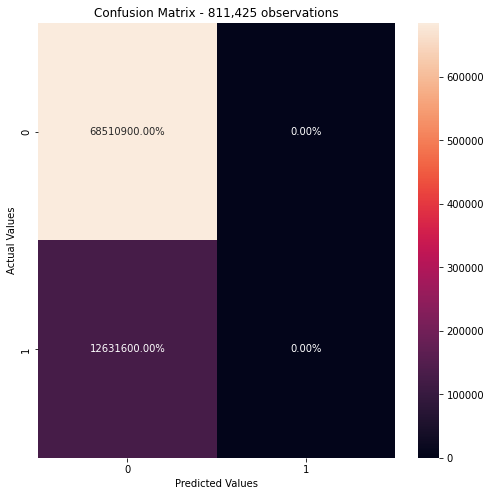

In [ ]:
logModel, pred_result_logr = validation(full_train_df, full_test_df, 
                                     sampling = 'down',
                                     model_type = 'logr', 
                                     best_parameters = log_best_parameters, 
                                     pipeline_fn = scaled_pipeline
                                )



In [ ]:
# from pyspark.sql.functions import lit
# from pyspark.mllib.evaluation import MulticlassMetrics
# from pyspark.ml.classification import LogisticRegression
# from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
# from pyspark.sql.functions import col

# # Load the train set
# train_set = spark.read.parquet(f"{blob_url}/train_set")

# # Make sure the target variable is not null
# train_set = train_set.where("DEP_DEL15 is not NULL")

# train_set = train_set.withColumn("PREV_DEP_DELAY", col("PREV_DEP_DELAY").cast('int'))

# # Use Vetor Assembler to create the features column
# features_to_keep = ['DISTANCE', 'PREV_DEP_DELAY', 'CRS_DEP_TIME', 'CRS_ARR_TIME']
# vectorAssembler = VectorAssembler(inputCols = features_to_keep, outputCol = 'features')
# train_df = vectorAssembler.transform(train_set)
# train_df = train_df.select(['features', 'DEP_DEL15']).withColumnRenamed("DEP_DEL15", "label")

# # Standardize Features using train set
# scaler = MinMaxScaler(inputCol="features", outputCol="featured_scaled")
# scaler_model = scaler.fit( train_df.select("features") )
# train_df = scaler_model.transform(train_df)

# # Train the logistic regression
# lr = LogisticRegression()
# lr_Model = lr.fit(train_df)

# # Load the dev set
# test_set = spark.read.parquet(f"{blob_url}/test_set")
# test_set = test_set.where("DEP_DEL15 is not NULL")

# test_set = test_set.withColumn("PREV_DEP_DELAY", col("PREV_DEP_DELAY").cast('int'))

# # Create the features column
# test_df = vectorAssembler.transform(test_set)
# test_df = test_df.select(['features', 'DEP_DEL15']).withColumnRenamed("DEP_DEL15", "label")

# # Standardize Features using train set
# test_df = scaler_model.transform(test_df)

# # Use the model on the test set
# testSet = lr_Model.transform(test_df)

In [ ]:
# print("Model 1 was fit using parameters: ")
# print(lr_Model.extractParamMap())

Model 1 was fit using parameters: 
{Param(parent='LogisticRegression_7d58c5a063e0', name='aggregationDepth', doc='suggested depth for treeAggregate (>= 2).'): 2, Param(parent='LogisticRegression_7d58c5a063e0', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.0, Param(parent='LogisticRegression_7d58c5a063e0', name='family', doc='The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial'): 'auto', Param(parent='LogisticRegression_7d58c5a063e0', name='featuresCol', doc='features column name.'): 'features', Param(parent='LogisticRegression_7d58c5a063e0', name='fitIntercept', doc='whether to fit an intercept term.'): True, Param(parent='LogisticRegression_7d58c5a063e0', name='labelCol', doc='label column name.'): 'label', Param(parent='LogisticRegression_7d58c5a063e0', name='maxBlockSizeInMB', do

## Evaluate Log Model

In [ ]:
# cm = testSet.groupBy('label','prediction').count().sort('label','prediction')
# print("Confusion matrix")
# cm.show()

Confusion matrix, without normalization
[[  91605  912096]
 [  49171 4760222]]


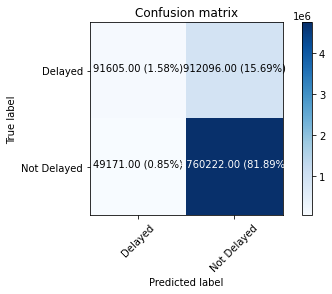

In [ ]:
# import itertools
# from sklearn.metrics import confusion_matrix

# class_names=['Delayed','Not Delayed']

# def plot_confusion_matrix(cm, classes,
#                           normalize=False,
#                           title='Confusion matrix',
#                           cmap=plt.cm.Blues):
#     """
#     This function prints and plots the confusion matrix.
#     Normalization can be applied by setting `normalize=True`.
#     """
#     if normalize:
#         cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
#     else:
#         print('Confusion matrix, without normalization')

#     print(cm)

#     plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
#     tick_marks = np.arange(len(classes))
#     plt.xticks(tick_marks, classes, rotation=45)
#     plt.yticks(tick_marks, classes)

#     fmt = '.2f' if normalize else 'd'
#     thresh = cm.max() / 2.
#     total_rows = cm.sum()
#     for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#         value = format(cm[i, j], fmt)
#         per = format(cm[i, j]/total_rows * 100, '.2f')
#         plt.text(j, i, f'{value} ({per}%)',
#                  horizontalalignment="center",
#                  color="white" if cm[i, j] > thresh else "black")

#     plt.tight_layout()
#     plt.ylabel('True label')
#     plt.xlabel('Predicted label')


# y_true = testSet.select("label")
# y_true = y_true.toPandas()
# y_true['label'] = y_true['label'].replace([0],'Not Delayed')
# y_true['label'] = y_true['label'].replace([1],'Delayed')

# y_pred = testSet.select("prediction")
# y_pred = y_pred.toPandas()
# y_pred['prediction'] = y_pred['prediction'].replace([0],'Not Delayed')
# y_pred['prediction'] = y_pred['prediction'].replace([1],'Delayed')

# cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_names)
# plt.figure()
# plot_confusion_matrix(cnf_matrix, classes=class_names,
#                       title='Confusion matrix')
# plt.show()

In [ ]:
# # https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc


# trainingSummary = lr_Model.summary
# roc = trainingSummary.roc.toPandas()
# plt.plot(roc['FPR'],roc['TPR'])
# plt.ylabel('False Positive Rate')
# plt.xlabel('True Positive Rate')
# plt.title('ROC Curve')
# plt.show()
# print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
<command-2647101326233856> in <cell line: 4>()
      2 
      3 
----> 4 trainingSummary = lr_Model.summary
      5 roc = trainingSummary.roc.toPandas()
      6 plt.plot(roc['FPR'],roc['TPR'])

NameError: name 'lr_Model' is not defined

## Interpretation

In [ ]:
import shap

# https://www.databricks.com/blog/2022/02/02/scaling-shap-calculations-with-pyspark-and-pandas-udf.html
# https://www.databricks.com/blog/2022/02/02/scaling-shap-calculations-with-pyspark-and-pandas-udf.html


# Decision Tree

In [ ]:
from  mlflow.tracking import MlflowClient
client = MlflowClient()
experiments = client.search_experiments()
experiments[0]

Out[36]: <Experiment: artifact_location='dbfs:/databricks/mlflow-tracking/1215577238249790', creation_time=1670170691895, experiment_id='1215577238249790', last_update_time=1670174775783, lifecycle_stage='active', name='/Users/limdo@berkeley.edu/w261_modelling_dev-feature_selection_mlflow', tags={'mlflow.experiment.sourceName': '/Users/limdo@berkeley.edu/w261_modelling_dev-feature_selection_mlflow',
 'mlflow.experimentType': 'NOTEBOOK',
 'mlflow.ownerEmail': 'limdo@berkeley.edu',
 'mlflow.ownerId': '2036193007520569'}>

In [ ]:
mlflow.create_experiment(name='/Users/limdo@berkeley.edu/hyperparam_tuning')

Out[39]: '1215577238252958'

## Train DT Model

In [ ]:
paramGrid_dt = {'maxDepth': [10],
                    'maxBins': [350]}  



In [ ]:
dt_best_parameters, dt_best_score = blocktimeSeriesCV(parquet_string='full', 
                                                      sampling = 'down',
                                                      param_grid = paramGrid_dt, 
                                                      pipeline_fn = scaled_pipeline, 
                                                      model_type='dt',
                                                      k=2,
                                                      metric='f2'
)

dtModel, pred_result_dt = validation(full_train_df, full_test_df, 
                                     sampling = 'down',
                                     model_type = 'dt', 
                                     best_parameters = dt_best_parameters, 
                                     pipeline_fn = scaled_pipeline
                                )

Parameters: {'maxDepth': 10, 'maxBins': 350}


Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
 CV Result of dt
           Train   Test
ROC AUC    0.617  0.583
F2 Score   0.557  0.357
Recall     0.547  0.443
Precision  0.597  0.202
Accuracy   0.588  0.642


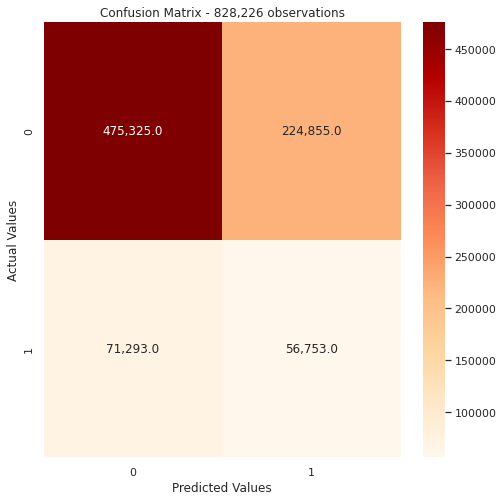

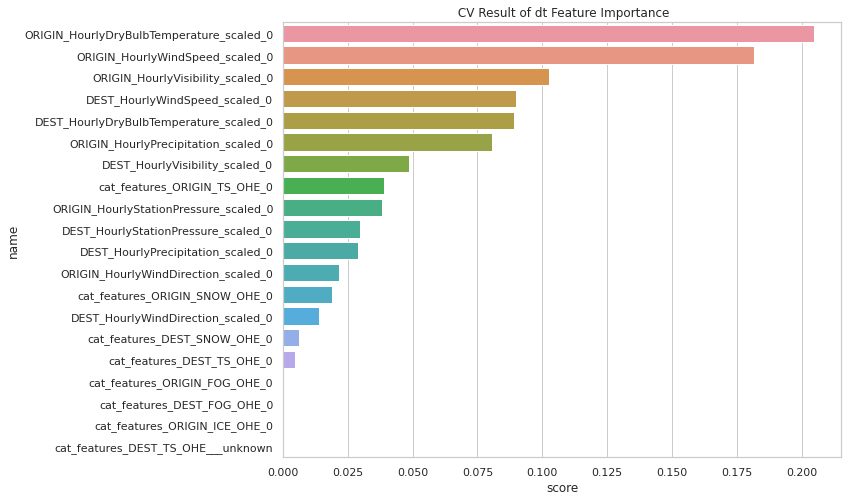

In [ ]:
# FOR FEATURE SELECTION, QUICK EXPERIMENTATIONS

flight_features_cont = [
#     'PREV_DEP_DELAY',
#     'AVG_DELAY_ORIGIN_LAST_12',
#     'PER_DELAY_15_ORIGIN_LAST_12',
#     'AVG_DELAY_ORIGIN_LAST_6',
#     'PER_DELAY_15_ORIGIN_LAST_6',
#     'AVG_DELAY_ORIGIN_LAST_3',
#     'PER_DELAY_15_ORIGIN_LAST_3',
#     'AVG_DELAY_ORIGIN_LAST_1',
#     'PER_DELAY_15_ORIGIN_LAST_1'
]

airport_capacity_cont = [
#     'Q','Qs','Q1h_sum','Qs1h_sum','R1h','Q2h_sum','Qs2h_sum','R2h','Q3h_sum','Qs3h_sum','R3h','Q4h_sum','Qs4h_sum','R4h','Q5h_sum','Qs5h_sum','R5h','Q6h_sum','Qs6h_sum','R6h','Q7h_sum','Qs7h_sum','R7h','Q8h_sum','Qs8h_sum','R8h','Q9h_sum','Qs9h_sum','R9h','Q10h_sum','Qs10h_sum','R10h','Q11h_sum','Qs11h_sum','R11h','Q12h_sum','Qs12h_sum','R12h','N','N1h_sum','N2h_sum','N3h_sum','N4h_sum','N5h_sum','N6h_sum','N7h_sum','N8h_sum','N9h_sum','N10h_sum','N11h_sum','N12h_sum'
]

page_rank_cont = [
#  'PageRank_origin',
#    'PageRank_dest'
]

flight_features_cat = [
#     "DAY_OF_MONTH"
]

weather_features_cont = [
    'ORIGIN_HourlyPrecipitation',
    'ORIGIN_HourlyStationPressure',
    'ORIGIN_HourlyWindDirection',
    'ORIGIN_HourlyWindSpeed',
    'ORIGIN_HourlyDryBulbTemperature',
    'ORIGIN_HourlyVisibility',
    'DEST_HourlyPrecipitation',
    'DEST_HourlyStationPressure',
    'DEST_HourlyWindDirection',
    'DEST_HourlyWindSpeed',
    'DEST_HourlyDryBulbTemperature',
    'DEST_HourlyVisibility'
]

weather_features_binary = [
    'ORIGIN_TS',
    'ORIGIN_ICE',
    'ORIGIN_SNOW',
    'ORIGIN_FOG',
    'DEST_TS',
    'DEST_ICE',
    'DEST_SNOW',
    'DEST_FOG'
]

weather_features_cat = []

graph_features_cat = [
#     "delay_state"
]

cont_feat = [*flight_features_cont, *weather_features_cont, *airport_capacity_cont, *page_rank_cont]

columns_categorical = [*flight_features_cat, *weather_features_binary, *graph_features_cat]

# yr_train_df = read_clean(f"train_delay_set1").cache()
# yr_train_df.count()

# yr_test_df = read_clean(f"dev_delay_set1").cache()
# yr_test_df.count()

paramGrid_dt = {'maxDepth': 10,
                    'maxBins': 350
               }

dtModel, pred_result_dt = validation(yr_train_df, yr_test_df, 
                                     sampling = 'down',
                                     model_type = 'dt', 
                                     best_parameters = paramGrid_dt, 
                                     pipeline_fn = scaled_pipeline,
                                     comments = "weather_features"
                                )

Out[34]: [<Experiment: artifact_location='dbfs:/databricks/mlflow-tracking/1215577238249790', creation_time=1670170691895, experiment_id='1215577238249790', last_update_time=1670174775783, lifecycle_stage='active', name='/Users/limdo@berkeley.edu/w261_modelling_dev-feature_selection_mlflow', tags={'mlflow.experiment.sourceName': '/Users/limdo@berkeley.edu/w261_modelling_dev-feature_selection_mlflow',
  'mlflow.experimentType': 'NOTEBOOK',
  'mlflow.ownerEmail': 'limdo@berkeley.edu',
  'mlflow.ownerId': '2036193007520569'}>,
 <Experiment: artifact_location='dbfs:/databricks/mlflow-tracking/1215577238248883', creation_time=1670167960784, experiment_id='1215577238248883', last_update_time=1670169121633, lifecycle_stage='active', name='/Users/limdo@berkeley.edu/w261_modelling_dev-mlflow', tags={'mlflow.experiment.sourceName': '/Users/limdo@berkeley.edu/w261_modelling_dev-mlflow',
  'mlflow.experimentType': 'NOTEBOOK',
  'mlflow.ownerEmail': 'limdo@berkeley.edu',
  'mlflow.ownerId': '203619

Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
 CV Result of dt
           Train   Test
ROC AUC    0.758  0.741
F2 Score   0.624  0.494
Recall     0.600  0.538
Precision  0.746  0.372
Accuracy   0.698  0.788


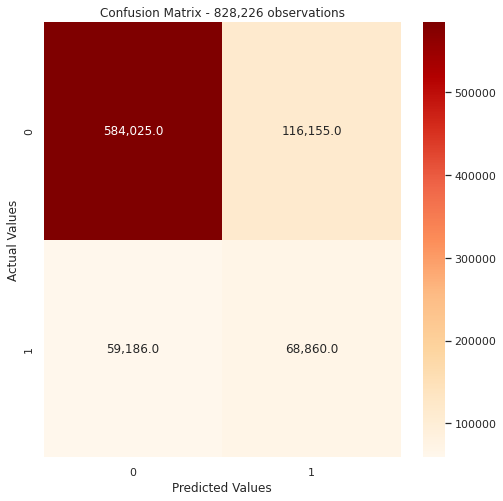

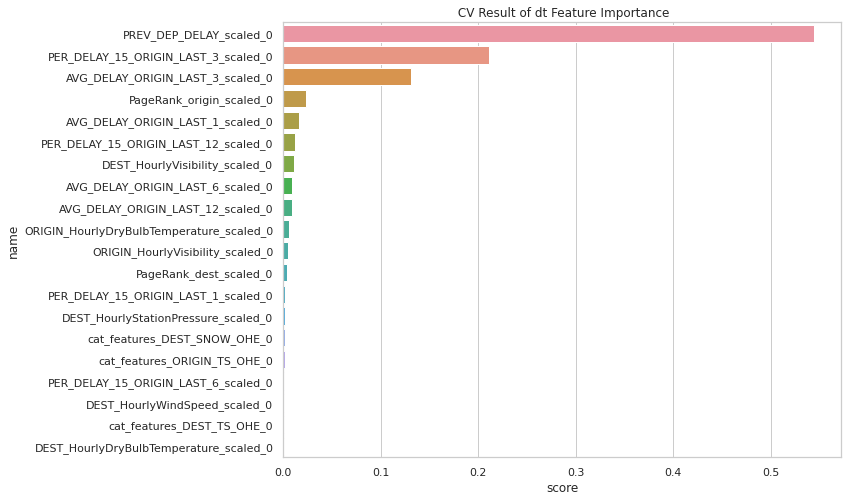

In [ ]:
# FOR FEATURE SELECTION, QUICK EXPERIMENTATIONS

flight_features_cont = [
    'PREV_DEP_DELAY',
    'AVG_DELAY_ORIGIN_LAST_12',
    'PER_DELAY_15_ORIGIN_LAST_12',
    'AVG_DELAY_ORIGIN_LAST_6',
    'PER_DELAY_15_ORIGIN_LAST_6',
    'AVG_DELAY_ORIGIN_LAST_3',
    'PER_DELAY_15_ORIGIN_LAST_3',
    'AVG_DELAY_ORIGIN_LAST_1',
    'PER_DELAY_15_ORIGIN_LAST_1'
]

airport_capacity_cont = [
#     'Q','Qs','Q1h_sum','Qs1h_sum','R1h','Q2h_sum','Qs2h_sum','R2h','Q3h_sum','Qs3h_sum','R3h','Q4h_sum','Qs4h_sum','R4h','Q5h_sum','Qs5h_sum','R5h','Q6h_sum','Qs6h_sum','R6h','Q7h_sum','Qs7h_sum','R7h','Q8h_sum','Qs8h_sum','R8h','Q9h_sum','Qs9h_sum','R9h','Q10h_sum','Qs10h_sum','R10h','Q11h_sum','Qs11h_sum','R11h','Q12h_sum','Qs12h_sum','R12h','N','N1h_sum','N2h_sum','N3h_sum','N4h_sum','N5h_sum','N6h_sum','N7h_sum','N8h_sum','N9h_sum','N10h_sum','N11h_sum','N12h_sum'
]

page_rank_cont = [
 'PageRank_origin',
   'PageRank_dest'
]

flight_features_cat = [
#     "DAY_OF_MONTH"
]

weather_features_cont = [
    'ORIGIN_HourlyPrecipitation',
    'ORIGIN_HourlyStationPressure',
    'ORIGIN_HourlyWindDirection',
    'ORIGIN_HourlyWindSpeed',
    'ORIGIN_HourlyDryBulbTemperature',
    'ORIGIN_HourlyVisibility',
    'DEST_HourlyPrecipitation',
    'DEST_HourlyStationPressure',
    'DEST_HourlyWindDirection',
    'DEST_HourlyWindSpeed',
    'DEST_HourlyDryBulbTemperature',
    'DEST_HourlyVisibility'
]

weather_features_binary = [
    'ORIGIN_TS',
    'ORIGIN_ICE',
    'ORIGIN_SNOW',
    'ORIGIN_FOG',
    'DEST_TS',
    'DEST_ICE',
    'DEST_SNOW',
    'DEST_FOG'
]

weather_features_cat = []

graph_features_cat = [
#     "delay_state"
]

cont_feat = [*flight_features_cont, *weather_features_cont, *airport_capacity_cont, *page_rank_cont]

columns_categorical = [*flight_features_cat, *weather_features_binary, *graph_features_cat]

# yr_train_df = read_clean(f"train_delay_set1").cache()
# yr_train_df.count()

# yr_test_df = read_clean(f"dev_delay_set1").cache()
# yr_test_df.count()

paramGrid_dt = {'maxDepth': 10,
                    'maxBins': 350
               }

dtModel, pred_result_dt = validation(yr_train_df, yr_test_df, 
                                     sampling = 'down',
                                     model_type = 'dt', 
                                     best_parameters = paramGrid_dt, 
                                     pipeline_fn = scaled_pipeline,
                                     comments = "prev_delay, weather"
                                )

Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
 CV Result of dt
           Train   Test
ROC AUC    0.758  0.741
F2 Score   0.624  0.494
Recall     0.600  0.538
Precision  0.746  0.372
Accuracy   0.698  0.788


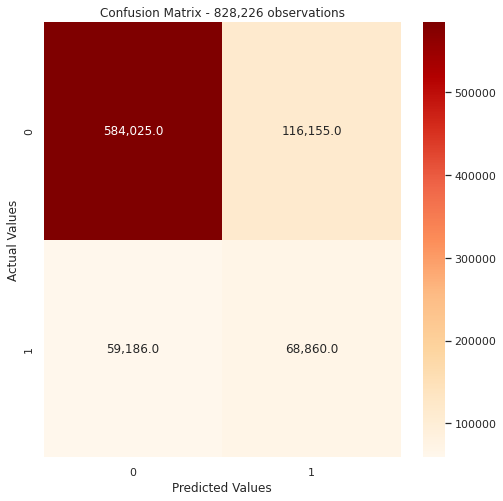

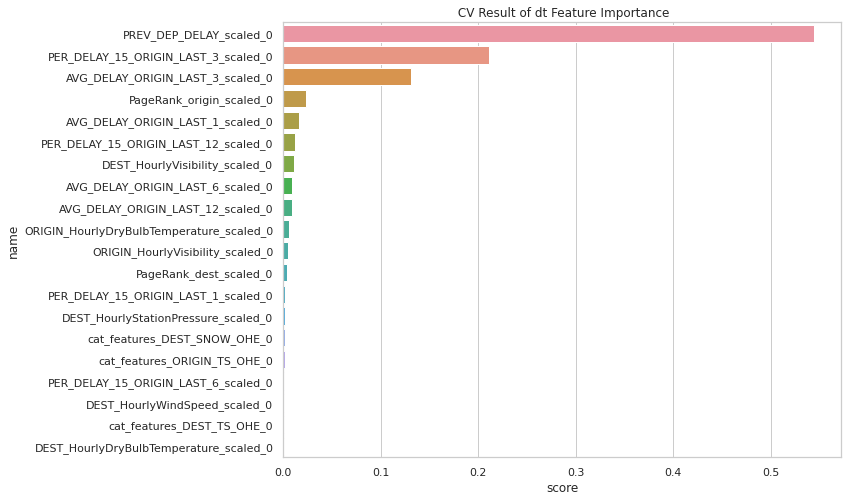

In [ ]:
flight_features_cont = [
    'PREV_DEP_DELAY',
    'AVG_DELAY_ORIGIN_LAST_12',
    'PER_DELAY_15_ORIGIN_LAST_12',
    'AVG_DELAY_ORIGIN_LAST_6',
    'PER_DELAY_15_ORIGIN_LAST_6',
    'AVG_DELAY_ORIGIN_LAST_3',
    'PER_DELAY_15_ORIGIN_LAST_3',
    'AVG_DELAY_ORIGIN_LAST_1',
    'PER_DELAY_15_ORIGIN_LAST_1'
]

airport_capacity_cont = [
#     'Q','Qs','Q1h_sum','Qs1h_sum','R1h','Q2h_sum','Qs2h_sum','R2h','Q3h_sum','Qs3h_sum','R3h','Q4h_sum','Qs4h_sum','R4h','Q5h_sum','Qs5h_sum','R5h','Q6h_sum','Qs6h_sum','R6h','Q7h_sum','Qs7h_sum','R7h','Q8h_sum','Qs8h_sum','R8h','Q9h_sum','Qs9h_sum','R9h','Q10h_sum','Qs10h_sum','R10h','Q11h_sum','Qs11h_sum','R11h','Q12h_sum','Qs12h_sum','R12h','N','N1h_sum','N2h_sum','N3h_sum','N4h_sum','N5h_sum','N6h_sum','N7h_sum','N8h_sum','N9h_sum','N10h_sum','N11h_sum','N12h_sum'
]

page_rank_cont = [
#  'PageRank_origin',
#    'PageRank_dest'
]

flight_features_cat = [
#     "DAY_OF_MONTH"
]

weather_features_cont = [
    'ORIGIN_HourlyPrecipitation',
    'ORIGIN_HourlyStationPressure',
    'ORIGIN_HourlyWindDirection',
    'ORIGIN_HourlyWindSpeed',
    'ORIGIN_HourlyDryBulbTemperature',
    'ORIGIN_HourlyVisibility',
    'DEST_HourlyPrecipitation',
    'DEST_HourlyStationPressure',
    'DEST_HourlyWindDirection',
    'DEST_HourlyWindSpeed',
    'DEST_HourlyDryBulbTemperature',
    'DEST_HourlyVisibility'
]

weather_features_binary = [
    'ORIGIN_TS',
    'ORIGIN_ICE',
    'ORIGIN_SNOW',
    'ORIGIN_FOG',
    'DEST_TS',
    'DEST_ICE',
    'DEST_SNOW',
    'DEST_FOG'
]

weather_features_cat = []

graph_features_cat = [
    "delay_state"
]

# yr_train_df = read_clean(f"train_delay_set1").cache()
# yr_train_df.count()

# yr_test_df = read_clean(f"dev_delay_set1").cache()
# yr_test_df.count()

paramGrid_dt = {'maxDepth': 10,
                    'maxBins': 350
               }

dtModel, pred_result_dt = validation(yr_train_df, yr_test_df, 
                                     sampling = 'down',
                                     model_type = 'dt', 
                                     best_parameters = paramGrid_dt, 
                                     pipeline_fn = scaled_pipeline,
                                     comments = "prev_delay, weather, delay_state"
                                )

Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
 CV Result of dt
           Train   Test
ROC AUC    0.758  0.741
F2 Score   0.624  0.494
Recall     0.600  0.538
Precision  0.746  0.372
Accuracy   0.698  0.788


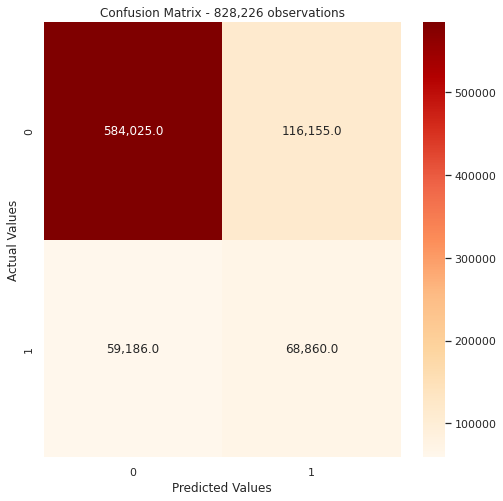

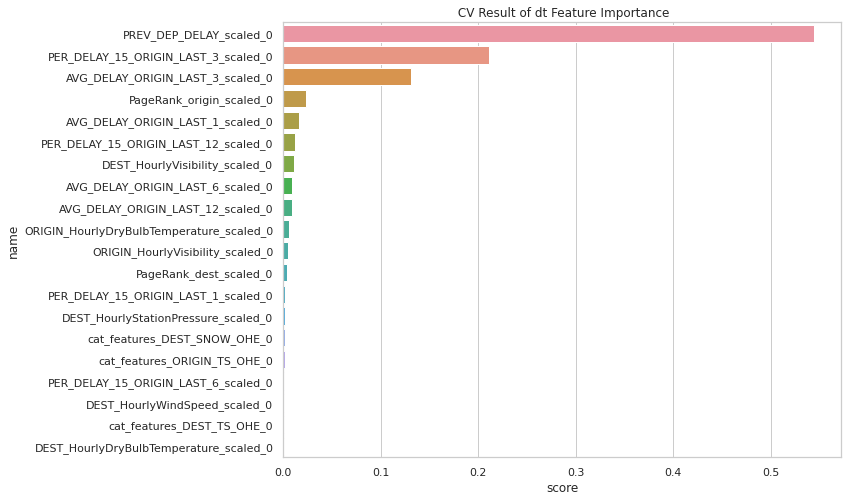

In [ ]:
flight_features_cont = [
    'PREV_DEP_DELAY',
    'AVG_DELAY_ORIGIN_LAST_12',
    'PER_DELAY_15_ORIGIN_LAST_12',
    'AVG_DELAY_ORIGIN_LAST_6',
    'PER_DELAY_15_ORIGIN_LAST_6',
    'AVG_DELAY_ORIGIN_LAST_3',
    'PER_DELAY_15_ORIGIN_LAST_3',
    'AVG_DELAY_ORIGIN_LAST_1',
    'PER_DELAY_15_ORIGIN_LAST_1'
]

airport_capacity_cont = [
#     'Q','Qs','Q1h_sum','Qs1h_sum','R1h','Q2h_sum','Qs2h_sum','R2h','Q3h_sum','Qs3h_sum','R3h','Q4h_sum','Qs4h_sum','R4h','Q5h_sum','Qs5h_sum','R5h','Q6h_sum','Qs6h_sum','R6h','Q7h_sum','Qs7h_sum','R7h','Q8h_sum','Qs8h_sum','R8h','Q9h_sum','Qs9h_sum','R9h','Q10h_sum','Qs10h_sum','R10h','Q11h_sum','Qs11h_sum','R11h','Q12h_sum','Qs12h_sum','R12h','N','N1h_sum','N2h_sum','N3h_sum','N4h_sum','N5h_sum','N6h_sum','N7h_sum','N8h_sum','N9h_sum','N10h_sum','N11h_sum','N12h_sum'
]

page_rank_cont = [
 'PageRank_origin',
   'PageRank_dest'
]

flight_features_cat = [
    "DAY_OF_MONTH",
    "HOUR_DEPT"
]

weather_features_cont = [
    'ORIGIN_HourlyPrecipitation',
    'ORIGIN_HourlyStationPressure',
    'ORIGIN_HourlyWindDirection',
    'ORIGIN_HourlyWindSpeed',
    'ORIGIN_HourlyDryBulbTemperature',
    'ORIGIN_HourlyVisibility',
    'DEST_HourlyPrecipitation',
    'DEST_HourlyStationPressure',
    'DEST_HourlyWindDirection',
    'DEST_HourlyWindSpeed',
    'DEST_HourlyDryBulbTemperature',
    'DEST_HourlyVisibility'
]

weather_features_binary = [
    'ORIGIN_TS',
    'ORIGIN_ICE',
    'ORIGIN_SNOW',
    'ORIGIN_FOG',
    'DEST_TS',
    'DEST_ICE',
    'DEST_SNOW',
    'DEST_FOG'
]

weather_features_cat = []

graph_features_cat = [
    "delay_state"
]

# yr_train_df = read_clean(f"train_delay_set1").cache()
# yr_train_df.count()

# yr_test_df = read_clean(f"dev_delay_set1").cache()
# yr_test_df.count()

paramGrid_dt = {'maxDepth': 10,
                    'maxBins': 350
               }

dtModel, pred_result_dt = validation(yr_train_df, yr_test_df, 
                                     sampling = 'down',
                                     model_type = 'dt', 
                                     best_parameters = paramGrid_dt, 
                                     pipeline_fn = scaled_pipeline,
                                     comments = "prevdelay, allweather, delay_state, page, seasonality"
                                )

Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
 CV Result of dt
           Train   Test
ROC AUC    0.980  0.602
F2 Score   0.901  0.446
Recall     0.888  0.562
Precision  0.956  0.245
Accuracy   0.924  0.665


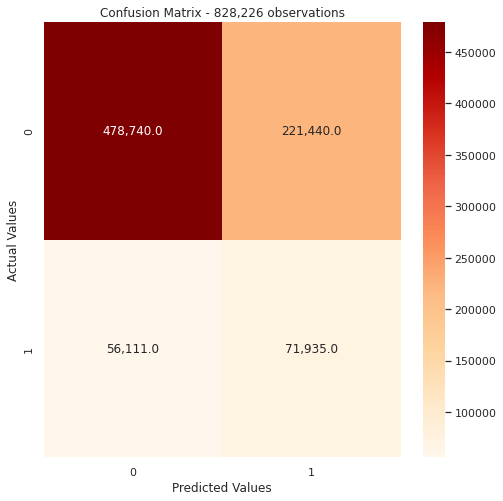

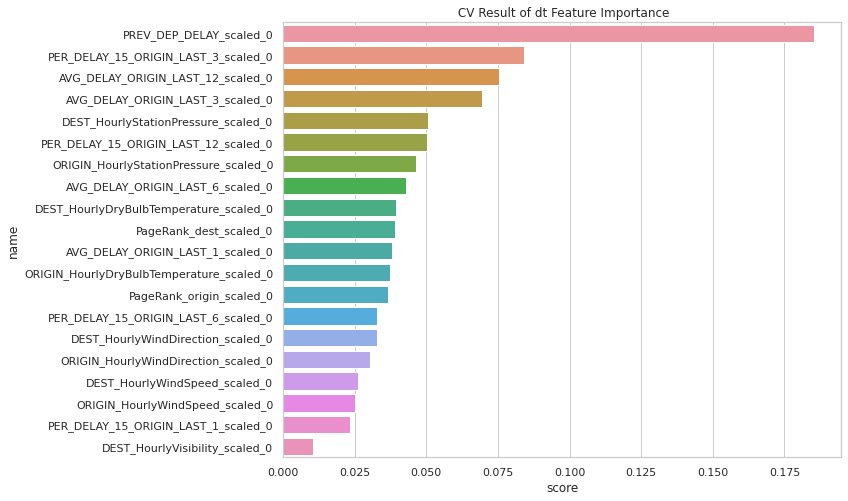

In [ ]:
flight_features_cont = [
    'PREV_DEP_DELAY',
    'AVG_DELAY_ORIGIN_LAST_12',
    'PER_DELAY_15_ORIGIN_LAST_12',
    'AVG_DELAY_ORIGIN_LAST_6',
    'PER_DELAY_15_ORIGIN_LAST_6',
    'AVG_DELAY_ORIGIN_LAST_3',
    'PER_DELAY_15_ORIGIN_LAST_3',
    'AVG_DELAY_ORIGIN_LAST_1',
    'PER_DELAY_15_ORIGIN_LAST_1'
]

airport_capacity_cont = [
#     'Q','Qs','Q1h_sum','Qs1h_sum','R1h','Q2h_sum','Qs2h_sum','R2h','Q3h_sum','Qs3h_sum','R3h','Q4h_sum','Qs4h_sum','R4h','Q5h_sum','Qs5h_sum','R5h','Q6h_sum','Qs6h_sum','R6h','Q7h_sum','Qs7h_sum','R7h','Q8h_sum','Qs8h_sum','R8h','Q9h_sum','Qs9h_sum','R9h','Q10h_sum','Qs10h_sum','R10h','Q11h_sum','Qs11h_sum','R11h','Q12h_sum','Qs12h_sum','R12h','N','N1h_sum','N2h_sum','N3h_sum','N4h_sum','N5h_sum','N6h_sum','N7h_sum','N8h_sum','N9h_sum','N10h_sum','N11h_sum','N12h_sum'
]

page_rank_cont = [
 'PageRank_origin',
   'PageRank_dest'
]

flight_features_cat = [
    "DAY_OF_MONTH",
    "HOUR_DEPT"
]

weather_features_cont = [
    'ORIGIN_HourlyPrecipitation',
    'ORIGIN_HourlyStationPressure',
    'ORIGIN_HourlyWindDirection',
    'ORIGIN_HourlyWindSpeed',
    'ORIGIN_HourlyDryBulbTemperature',
    'ORIGIN_HourlyVisibility',
    'DEST_HourlyPrecipitation',
    'DEST_HourlyStationPressure',
    'DEST_HourlyWindDirection',
    'DEST_HourlyWindSpeed',
    'DEST_HourlyDryBulbTemperature',
    'DEST_HourlyVisibility'
]

weather_features_binary = [
    'ORIGIN_TS',
    'ORIGIN_ICE',
    'ORIGIN_SNOW',
    'ORIGIN_FOG',
    'DEST_TS',
    'DEST_ICE',
    'DEST_SNOW',
    'DEST_FOG'
]

weather_features_cat = []

graph_features_cat = [
    "delay_state"
]

# yr_train_df = read_clean(f"train_delay_set1").cache()
# yr_train_df.count()

# yr_test_df = read_clean(f"dev_delay_set1").cache()
# yr_test_df.count()

paramGrid_dt = {'maxDepth': 30,
                    'maxBins': 350
               }

dtModel, pred_result_dt = validation(yr_train_df, yr_test_df, 
                                     sampling = 'down',
                                     model_type = 'dt', 
                                     best_parameters = paramGrid_dt, 
                                     pipeline_fn = scaled_pipeline,
                                     comments = "prevdelay, allweather, delay_state, page, seasonality"
                                )

In [ ]:
flight_features_cont = [
    'PREV_DEP_DELAY',
    'AVG_DELAY_ORIGIN_LAST_12',
    'PER_DELAY_15_ORIGIN_LAST_12',
    'AVG_DELAY_ORIGIN_LAST_6',
    'PER_DELAY_15_ORIGIN_LAST_6',
    'AVG_DELAY_ORIGIN_LAST_3',
    'PER_DELAY_15_ORIGIN_LAST_3',
    'AVG_DELAY_ORIGIN_LAST_1',
    'PER_DELAY_15_ORIGIN_LAST_1'
]

airport_capacity_cont = [ 'Q1h_sum','Qs1h_sum','R1h','Q2h_sum','Qs2h_sum','R2h','Q3h_sum','Qs3h_sum','R3h','Q4h_sum','Qs4h_sum','R4h','Q5h_sum','Qs5h_sum','R5h','Q6h_sum','Qs6h_sum','R6h','Q7h_sum','Qs7h_sum','R7h','Q8h_sum','Qs8h_sum','R8h','Q9h_sum','Qs9h_sum','R9h','Q10h_sum','Qs10h_sum','R10h','Q11h_sum','Qs11h_sum','R11h','Q12h_sum','Qs12h_sum','R12h','N1h_sum','N2h_sum','N3h_sum','N4h_sum','N5h_sum','N6h_sum','N7h_sum','N8h_sum','N9h_sum','N10h_sum','N11h_sum','N12h_sum'
]

page_rank_cont = [
 'PageRank_origin',
   'PageRank_dest'
]

flight_features_cat = [
    "DAY_OF_MONTH",
    "HOUR_DEPT",
    "OP_UNIQUE_CARRIER",
    "DAY_OF_WEEK"    
]

weather_features_cont = [
    'ORIGIN_HourlyPrecipitation',
    'ORIGIN_HourlyStationPressure',
    'ORIGIN_HourlyWindDirection',
    'ORIGIN_HourlyWindSpeed',
    'ORIGIN_HourlyDryBulbTemperature',
    'ORIGIN_HourlyVisibility',
    'DEST_HourlyPrecipitation',
    'DEST_HourlyStationPressure',
    'DEST_HourlyWindDirection',
    'DEST_HourlyWindSpeed',
    'DEST_HourlyDryBulbTemperature',
    'DEST_HourlyVisibility'
]

weather_features_binary = [
    'ORIGIN_TS',
    'ORIGIN_ICE',
    'ORIGIN_SNOW',
    'ORIGIN_FOG',
    'DEST_TS',
    'DEST_ICE',
    'DEST_SNOW',
    'DEST_FOG'
]

weather_features_cat = []

graph_features_cat = [
    "delay_state"
]

yr_train_df = read_clean(f"train_delay_set1").cache()
yr_train_df.count()

yr_test_df = read_clean(f"dev_delay_set1").cache()
yr_test_df.count()

paramGrid_dt = {'maxDepth': 10,
                    'maxBins': 350,
                    
               }

dtModel, pred_result_dt = validation(yr_train_df, yr_test_df, 
                                     sampling = 'down',
                                     model_type = 'dt', 
                                     best_parameters = paramGrid_dt, 
                                     pipeline_fn = tree_pipeline,
                                     comments = "all_features"
                                )

---------------------------------------------------------------------------
The Python process exited with an unknown exit code.

The last 10 KB of the process's stderr and stdout can be found below. See driver logs for full logs.
---------------------------------------------------------------------------
Last messages on stderr:
Mon Dec  5 04:53:43 2022 Connection to spark from PID  1160
Mon Dec  5 04:53:43 2022 Initialized gateway on port 33103
Mon Dec  5 04:53:43 2022 Connected to spark.
Matplotlib is building the font cache; this may take a moment.
Unexpected internal error while setting REPL context in `pre_command_execute`: An error occurred while calling o364.tags. Trace:
py4j.security.Py4JSecurityException: Method public scala.collection.immutable.Map com.databricks.backend.common.rpc.CommandContext.tags() is not whitelisted on class class com.databricks.backend.common.rpc.CommandContext
	at py4j.security.WhitelistingPy4JSecurityManager.checkCall(WhitelistingPy4JSecurityManager

In [ ]:
display(yr_train_df.select("ORIGIN_HourlyWindSpeed"))

ORIGIN_HourlyWindSpeed
null
null
null
null
null
null
null
null
null
null


In [ ]:
"flight_features_cont = [
    'PREV_DEP_DELAY',
    'AVG_DELAY_ORIGIN_LAST_12',
    'PER_DELAY_15_ORIGIN_LAST_12',
    'AVG_DELAY_ORIGIN_LAST_6',
    'PER_DELAY_15_ORIGIN_LAST_6',
    'AVG_DELAY_ORIGIN_LAST_3',
    'PER_DELAY_15_ORIGIN_LAST_3',
    'AVG_DELAY_ORIGIN_LAST_1',
    'PER_DELAY_15_ORIGIN_LAST_1'
]

airport_capacity_cont = [
#     'Q','Qs','Q1h_sum','Qs1h_sum','R1h','Q2h_sum','Qs2h_sum','R2h','Q3h_sum','Qs3h_sum','R3h','Q4h_sum','Qs4h_sum','R4h','Q5h_sum','Qs5h_sum','R5h','Q6h_sum','Qs6h_sum','R6h','Q7h_sum','Qs7h_sum','R7h','Q8h_sum','Qs8h_sum','R8h','Q9h_sum','Qs9h_sum','R9h','Q10h_sum','Qs10h_sum','R10h','Q11h_sum','Qs11h_sum','R11h','Q12h_sum','Qs12h_sum','R12h','N','N1h_sum','N2h_sum','N3h_sum','N4h_sum','N5h_sum','N6h_sum','N7h_sum','N8h_sum','N9h_sum','N10h_sum','N11h_sum','N12h_sum'
]

page_rank_cont = [
 'PageRank_origin',
   'PageRank_dest'
]

flight_features_cat = [
    "DAY_OF_MONTH",
    "HOUR_DEPT",
    "DAY_OF_WEEK",
    'OP_UNIQUE_CARRIER'
]

weather_features_cont = [
    'ORIGIN_HourlyPrecipitation',
    'ORIGIN_HourlyStationPressure',
    'ORIGIN_HourlyWindDirection',
    'ORIGIN_HourlyWindSpeed',
    'ORIGIN_HourlyDryBulbTemperature',
    'ORIGIN_HourlyVisibility',
    'DEST_HourlyPrecipitation',
    'DEST_HourlyStationPressure',
    'DEST_HourlyWindDirection',
    'DEST_HourlyWindSpeed',
    'DEST_HourlyDryBulbTemperature',
    'DEST_HourlyVisibility'
]

weather_features_binary = [
    'ORIGIN_TS',
    'ORIGIN_ICE',
    'ORIGIN_SNOW',
    'ORIGIN_FOG',
    'DEST_TS',
    'DEST_ICE',
    'DEST_SNOW',
    'DEST_FOG'
]

weather_features_cat = []

graph_features_cat = [
    "delay_state"
]

# yr_train_df = read_clean(f"train_delay_set1").cache()
# yr_train_df.count()

# yr_test_df = read_clean(f"dev_delay_set1").cache()
# yr_test_df.count()

paramGrid_dt = {'maxDepth': 30,
                    'maxBins': 100,
                    
               }

dtModel, pred_result_dt = validation(yr_train_df, yr_test_df, 
                                     sampling = 'down',
                                     model_type = 'dt', 
                                     best_parameters = paramGrid_dt, 
                                     pipeline_fn = scaled_pipeline,
                                     comments = "prevdelay, allweather, delay_state, page, seasonality, airline"
                                )

  File "<command-1215577238257314>", line 1
    "flight_features_cont = [
                             ^
SyntaxError: EOL while scanning string literal


Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
 CV Result of dt
           Train   Test
ROC AUC    0.982  0.601
F2 Score   0.906  0.445
Recall     0.894  0.562
Precision  0.959  0.242
Accuracy   0.928  0.660


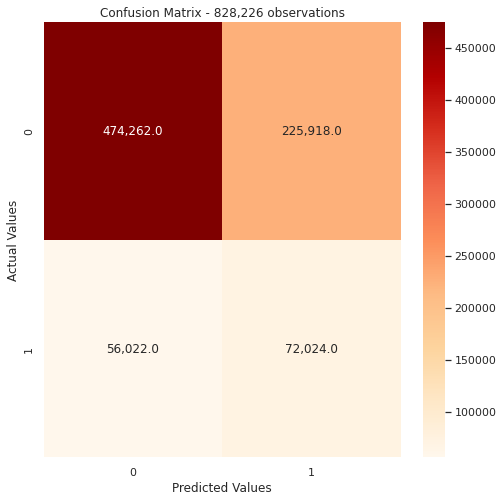

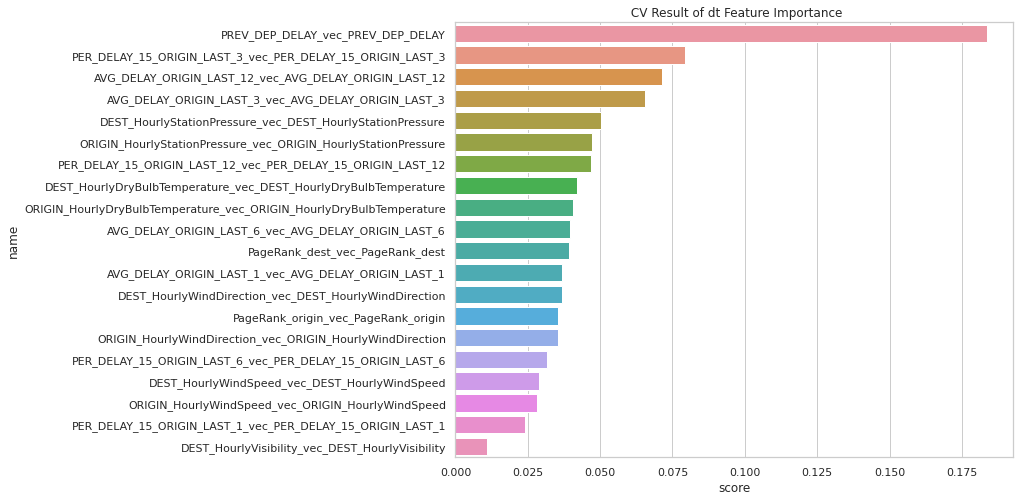

In [ ]:
flight_features_cont = [
    'PREV_DEP_DELAY',
    'AVG_DELAY_ORIGIN_LAST_12',
    'PER_DELAY_15_ORIGIN_LAST_12',
    'AVG_DELAY_ORIGIN_LAST_6',
    'PER_DELAY_15_ORIGIN_LAST_6',
    'AVG_DELAY_ORIGIN_LAST_3',
    'PER_DELAY_15_ORIGIN_LAST_3',
    'AVG_DELAY_ORIGIN_LAST_1',
    'PER_DELAY_15_ORIGIN_LAST_1'
]

airport_capacity_cont = [
#     'Q','Qs','Q1h_sum','Qs1h_sum','R1h','Q2h_sum','Qs2h_sum','R2h','Q3h_sum','Qs3h_sum','R3h','Q4h_sum','Qs4h_sum','R4h','Q5h_sum','Qs5h_sum','R5h','Q6h_sum','Qs6h_sum','R6h','Q7h_sum','Qs7h_sum','R7h','Q8h_sum','Qs8h_sum','R8h','Q9h_sum','Qs9h_sum','R9h','Q10h_sum','Qs10h_sum','R10h','Q11h_sum','Qs11h_sum','R11h','Q12h_sum','Qs12h_sum','R12h','N','N1h_sum','N2h_sum','N3h_sum','N4h_sum','N5h_sum','N6h_sum','N7h_sum','N8h_sum','N9h_sum','N10h_sum','N11h_sum','N12h_sum'
]

page_rank_cont = [
 'PageRank_origin',
   'PageRank_dest'
]

flight_features_cat = [
    "DAY_OF_MONTH",
    "HOUR_DEPT",
    'OP_UNIQUE_CARRIER'
]

weather_features_cont = [
    'ORIGIN_HourlyPrecipitation',
    'ORIGIN_HourlyStationPressure',
    'ORIGIN_HourlyWindDirection',
    'ORIGIN_HourlyWindSpeed',
    'ORIGIN_HourlyDryBulbTemperature',
    'ORIGIN_HourlyVisibility',
    'DEST_HourlyPrecipitation',
    'DEST_HourlyStationPressure',
    'DEST_HourlyWindDirection',
    'DEST_HourlyWindSpeed',
    'DEST_HourlyDryBulbTemperature',
    'DEST_HourlyVisibility'
]

weather_features_binary = [
    'ORIGIN_TS',
    'ORIGIN_ICE',
    'ORIGIN_SNOW',
    'ORIGIN_FOG',
    'DEST_TS',
    'DEST_ICE',
    'DEST_SNOW',
    'DEST_FOG'
]

weather_features_cat = []

graph_features_cat = [
    "delay_state"
]

# yr_train_df = read_clean(f"train_delay_set1").cache()
# yr_train_df.count()

# yr_test_df = read_clean(f"dev_delay_set1").cache()
# yr_test_df.count()

paramGrid_dt = {'maxDepth': 30,
                    'maxBins': 100,
                    
               }

dtModel, pred_result_dt = validation(yr_train_df, yr_test_df, 
                                     sampling = 'down',
                                     model_type = 'dt', 
                                     best_parameters = paramGrid_dt, 
                                     pipeline_fn = tree_pipeline,
                                     comments = "prevdelay, allweather, delay_state, page, seasonality, airline, tree pipeline"
                                )

Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
 CV Result of dt
           Train   Test
ROC AUC    0.758  0.741
F2 Score   0.624  0.494
Recall     0.600  0.538
Precision  0.746  0.372
Accuracy   0.698  0.788


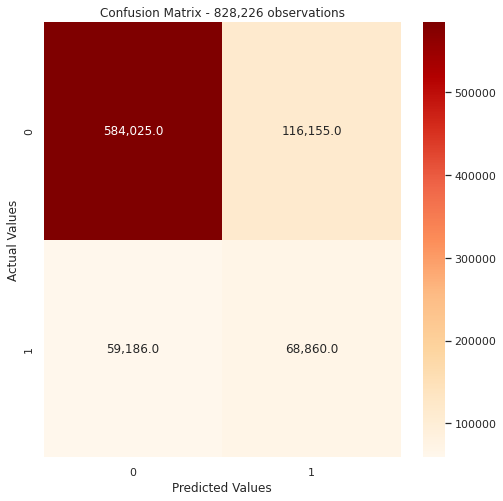

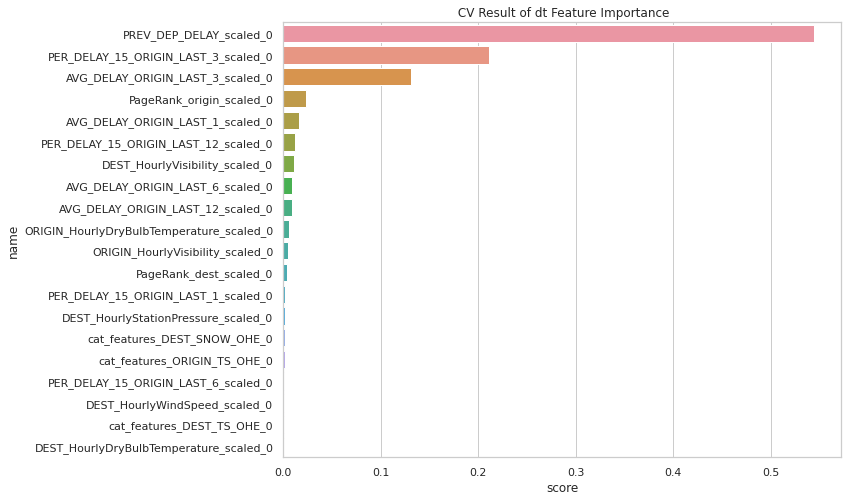

In [ ]:
flight_features_cont = [
    'PREV_DEP_DELAY',
    'AVG_DELAY_ORIGIN_LAST_12',
    'PER_DELAY_15_ORIGIN_LAST_12',
    'AVG_DELAY_ORIGIN_LAST_6',
    'PER_DELAY_15_ORIGIN_LAST_6',
    'AVG_DELAY_ORIGIN_LAST_3',
    'PER_DELAY_15_ORIGIN_LAST_3',
    'AVG_DELAY_ORIGIN_LAST_1',
    'PER_DELAY_15_ORIGIN_LAST_1'
]

airport_capacity_cont = [
#     'Q','Qs','Q1h_sum','Qs1h_sum','R1h','Q2h_sum','Qs2h_sum','R2h','Q3h_sum','Qs3h_sum','R3h','Q4h_sum','Qs4h_sum','R4h','Q5h_sum','Qs5h_sum','R5h','Q6h_sum','Qs6h_sum','R6h','Q7h_sum','Qs7h_sum','R7h','Q8h_sum','Qs8h_sum','R8h','Q9h_sum','Qs9h_sum','R9h','Q10h_sum','Qs10h_sum','R10h','Q11h_sum','Qs11h_sum','R11h','Q12h_sum','Qs12h_sum','R12h','N','N1h_sum','N2h_sum','N3h_sum','N4h_sum','N5h_sum','N6h_sum','N7h_sum','N8h_sum','N9h_sum','N10h_sum','N11h_sum','N12h_sum'
]

page_rank_cont = [
#  'PageRank_origin',
#    'PageRank_dest'
]

flight_features_cat = [
#     "DAY_OF_MONTH",
#     "HOUR_DEPT"
]

weather_features_cont = [
#     'ORIGIN_HourlyPrecipitation',
#     'ORIGIN_HourlyStationPressure',
#     'ORIGIN_HourlyWindDirection',
#     'ORIGIN_HourlyWindSpeed',
#     'ORIGIN_HourlyDryBulbTemperature',
#     'ORIGIN_HourlyVisibility',
#     'DEST_HourlyPrecipitation',
#     'DEST_HourlyStationPressure',
#     'DEST_HourlyWindDirection',
#     'DEST_HourlyWindSpeed',
#     'DEST_HourlyDryBulbTemperature',
#     'DEST_HourlyVisibility'
]

weather_features_binary = [
#     'ORIGIN_TS',
#     'ORIGIN_ICE',
#     'ORIGIN_SNOW',
#     'ORIGIN_FOG',
#     'DEST_TS',
#     'DEST_ICE',
#     'DEST_SNOW',
#     'DEST_FOG'
]

weather_features_cat = []

graph_features_cat = [
#     "delay_state"
]

# yr_train_df = read_clean(f"train_delay_set1").cache()
# yr_train_df.count()

# yr_test_df = read_clean(f"dev_delay_set1").cache()
# yr_test_df.count()

paramGrid_dt = {'maxDepth': ,
                    'maxBins': 350
               }

dtModel, pred_result_dt = validation(yr_train_df, yr_test_df, 
                                     sampling = 'down',
                                     model_type = 'dt', 
                                     best_parameters = paramGrid_dt, 
                                     pipeline_fn = scaled_pipeline,
                                     comments = "prevdelay only"
                                )

In [ ]:
flight_features_cont = [
    'PREV_DEP_DELAY',
    'AVG_DELAY_ORIGIN_LAST_12',
    'PER_DELAY_15_ORIGIN_LAST_12',
    'AVG_DELAY_ORIGIN_LAST_6',
    'PER_DELAY_15_ORIGIN_LAST_6',
    'AVG_DELAY_ORIGIN_LAST_3',
    'PER_DELAY_15_ORIGIN_LAST_3',
    'AVG_DELAY_ORIGIN_LAST_1',
    'PER_DELAY_15_ORIGIN_LAST_1'
]

airport_capacity_cont = [
#     'Q','Qs','Q1h_sum','Qs1h_sum','R1h','Q2h_sum','Qs2h_sum','R2h','Q3h_sum','Qs3h_sum','R3h','Q4h_sum','Qs4h_sum','R4h','Q5h_sum','Qs5h_sum','R5h','Q6h_sum','Qs6h_sum','R6h','Q7h_sum','Qs7h_sum','R7h','Q8h_sum','Qs8h_sum','R8h','Q9h_sum','Qs9h_sum','R9h','Q10h_sum','Qs10h_sum','R10h','Q11h_sum','Qs11h_sum','R11h','Q12h_sum','Qs12h_sum','R12h','N','N1h_sum','N2h_sum','N3h_sum','N4h_sum','N5h_sum','N6h_sum','N7h_sum','N8h_sum','N9h_sum','N10h_sum','N11h_sum','N12h_sum'
]

page_rank_cont = [
 'PageRank_origin',
   'PageRank_dest'
]

flight_features_cat = [
    "DAY_OF_MONTH",
    "HOUR_DEPT",
    
]

weather_features_cont = [
    'ORIGIN_HourlyPrecipitation',
    'ORIGIN_HourlyStationPressure',
    'ORIGIN_HourlyWindDirection',
    'ORIGIN_HourlyWindSpeed',
    'ORIGIN_HourlyDryBulbTemperature',
    'ORIGIN_HourlyVisibility',
    'DEST_HourlyPrecipitation',
    'DEST_HourlyStationPressure',
    'DEST_HourlyWindDirection',
    'DEST_HourlyWindSpeed',
    'DEST_HourlyDryBulbTemperature',
    'DEST_HourlyVisibility'
]

weather_features_binary = [
    'ORIGIN_TS',
    'ORIGIN_ICE',
    'ORIGIN_SNOW',
    'ORIGIN_FOG',
    'DEST_TS',
    'DEST_ICE',
    'DEST_SNOW',
    'DEST_FOG'
]

weather_features_cat = []

graph_features_cat = [
    "delay_state"
]

# yr_train_df = read_clean(f"train_delay_set1").cache()
# yr_train_df.count()

# yr_test_df = read_clean(f"dev_delay_set1").cache()
# yr_test_df.count()

paramGrid_dt = {'maxDepth': ,
                    'maxBins': 350
               }

dtModel, pred_result_dt = validation(yr_train_df, yr_test_df, 
                                     sampling = 'down',
                                     model_type = 'dt', 
                                     best_parameters = paramGrid_dt, 
                                     pipeline_fn = scaled_pipeline,
                                     comments = "prevdelay only"
                                )

In [ ]:
yr_train_df.agg({'FL_DATE':'min'}).collect()[0][0], yr_train_df.agg({'FL_DATE':'max'}).collect()[0][0]
yr_test_df.agg({'FL_DATE':'min'}).collect()[0][0], yr_test_df.agg({'FL_DATE':'max'}).collect()[0][0]

Out[61]: ('2015-12-31', '2016-02-28')

 CV Result of dt
           Train   Test
ROC AUC    0.698  0.691
F2 Score   0.493  0.471
Recall     0.452  0.512
Precision  0.772  0.355
Accuracy   0.659  0.755


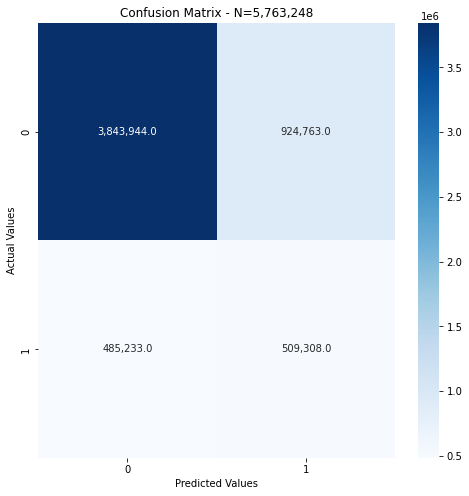

In [ ]:
dtModel, pred_result_dt = validation(full_train_df, full_test_df, 
                      model_type = 'dt', 
                      best_parameters = dt_best_parameters, 
                      pipeline_fn = tree_pipeline
                                    )

## Evaluate DT Model

In [ ]:
testSet = dt_Model.transform(test_df)

# Random Forest

## Train RF Model

In [ ]:
paramGrid_rf = {'maxDepth': [10],
                'numTrees': [10]}

rf_best_parameters, rf_best_score = blocktimeSeriesCV(parquet_string='full',
                                                      sampling = 'down',
                                                      param_grid = paramGrid_rf, 
                                                      pipeline_fn = tree_pipeline, 
                                                      model_type='rf', 
                                                        k=2, 
                                                        metric='f2'
                                                     )

Parameters: {'maxDepth': 10, 'numTrees': 10}
Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
    Number of training observations for fold number 1 is 2,051,849 with a f2 score of 0.46
------------------------------------------------------------
    Number of training observations for fold number 2 is 1,890,420 with a f2 score of 0.47
------------------------------------------------------------
    Number of training observations for fold number 3 is 2,563,472 with a f2 score of 0.55
------------------------------------------------------------
    Number of training observations for fold number 4 is 2,631,054 with a f2 score of 0.44
------------------------------------------------------------
    Number of training observations for fold number 5 is 1,013,380 with a f2 score of 0.34
------------------------------------------------------------
f2 was BETTER, new best score of 0.45
Training on full train dataset, and validating on dev dataset with best parameters from 

## Evaluate RF Model

 CV Result of rf
           Train   Test
ROC AUC    0.715  0.712
F2 Score   0.537  0.469
Recall     0.502  0.500
Precision  0.743  0.375
Accuracy   0.664  0.770
Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


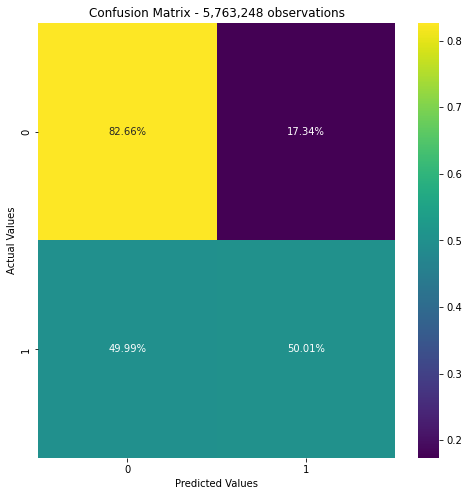

---------------------------------------------------------------------------
AttributeError                            Traceback (most recent call last)
<command-2647101326249003> in <cell line: 1>()
----> 1 rfModel, pred_result_rf = validation(full_train_df, full_test_df, sampling = 'down',
      2                       model_type = 'rf',
      3                       best_parameters = rf_best_parameters,
      4                       pipeline_fn = tree_pipeline
      5                                     )

<command-2647101326234406> in validation(df, validate_df, sampling, model_type, pipeline_fn, best_parameters)
    175     train_pred = model.transform(train_df)
    176     validate_pred = model.transform(validate_df)
--> 177     evaluate(model, train_pred, validate_pred, f' CV Result of {model_type}', validate_df)
    178 
    179     return model, validate_pred

<command-2647101326234406> in evaluate(model, preds_train, preds_valid, classifier_name, x_test)
    155 
    156     #

In [ ]:
rfModel, pred_result_rf = validation(full_train_df, full_test_df, sampling = 'down',
                      model_type = 'rf', 
                      best_parameters = rf_best_parameters, 
                      pipeline_fn = tree_pipeline
                                    )

In [ ]:
# # NOT BEING RUN AT THE MOMENT
# # source: https://shihaojran.com/distributed-machine-learning-using-pyspark/

# from pyspark.ml.feature import StringIndexer, OneHotEncoderEstimator

# carrier_indexer = StringIndexer(inputCol='OP_UNIQUE_CARRIER', outputCol='arr_idx').setHandleInvalid("keep")
# origin_indexer = StringIndexer(inputCol='ORIGIN', outputCol='org_idx').setHandleInvalid("keep")
# dest_indexer = StringIndexer(inputCol='DEST', outputCol='des_idx').setHandleInvalid("keep")

# # stay away from OneHotEncoderEstimator

# onehot = OneHotEncoderEstimator(inputCols=[carrier_indexer.getOutputCol(), origin_indexer.getOutputCol(),
#                                            dest_indexer.getOutputCol()],
#                                 outputCols=['carrier_dummy', 'origin_dummy', 'dest_dummy'])

# Gradient Boosted Model

In [ ]:
paramGrid_gbt = {'maxDepth':[5], #,6],
                 'maxBins': [350], #,400],
                 'maxIter': [6],
                 'stepSize': [0.13]}

gbt_best_parameters, gbt_best_score = blocktimeSeriesCV(parquet_string='full',
                                                        sampling='down',
                                                      param_grid = paramGrid_gbt, 
                                                      pipeline_fn = tree_pipeline, 
                                                      model_type='rf', 
                                                        k=2, 
                                                        metric='f2'
                                                     )

Parameters: {'maxDepth': 5, 'maxBins': 350, 'maxIter': 6, 'stepSize': 0.13}
Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
    Number of training observations for fold number 1 is 2,051,849 with a f2 score of 0.44
------------------------------------------------------------
    Number of training observations for fold number 2 is 1,890,420 with a f2 score of 0.46
------------------------------------------------------------
    Number of training observations for fold number 3 is 2,563,472 with a f2 score of 0.55
------------------------------------------------------------
    Number of training observations for fold number 4 is 2,631,054 with a f2 score of 0.43
------------------------------------------------------------
    Number of training observations for fold number 5 is 1,013,380 with a f2 score of 0.33
------------------------------------------------------------
f2 was BETTER, new best score of 0.44
Training on full train dataset, and validating on dev dat

In [ ]:
print(f'best parameters : {gbt_best_parameters}, best score: {gbt_best_score}')

 CV Result of gbt
           Train   Test
ROC AUC    0.716  0.716
F2 Score   0.532  0.466
Recall     0.496  0.495
Precision  0.748  0.378
Accuracy   0.664  0.773
Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


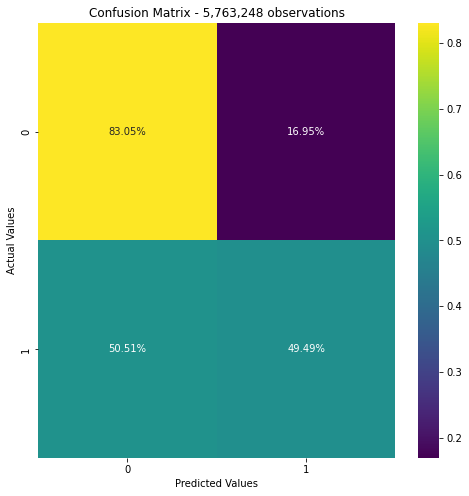

---------------------------------------------------------------------------
AttributeError                            Traceback (most recent call last)
<command-2647101326234793> in <cell line: 1>()
----> 1 gbtModel, pred_result_gbt = validation(full_train_df, full_test_df, sampling='down',
      2                       model_type = 'gbt',
      3                       best_parameters = gbt_best_parameters,
      4                       pipeline_fn = tree_pipeline
      5                                     )

<command-2647101326234406> in validation(df, validate_df, sampling, model_type, pipeline_fn, best_parameters)
    175     train_pred = model.transform(train_df)
    176     validate_pred = model.transform(validate_df)
--> 177     evaluate(model, train_pred, validate_pred, f' CV Result of {model_type}', validate_df)
    178 
    179     return model, validate_pred

<command-2647101326234406> in evaluate(model, preds_train, preds_valid, classifier_name, x_test)
    155 
    156    

In [ ]:
gbtModel, pred_result_gbt = validation(full_train_df, full_test_df, sampling='down',
                      model_type = 'gbt', 
                      best_parameters = gbt_best_parameters, 
                      pipeline_fn = tree_pipeline
                                    )

In [ ]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

param = ParamGridBuilder().build()

# cv = CrossValidator(estimator=pipeline,
#                     estimatorParamMaps=params,
#                     evaluator=evaluator,
#                     numFolds=5)

cv = cv.fit(train_set)

---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
<command-2647101326227153> in <cell line: 3>()
      2 param = ParamGridBuilder().build()
      3 cv = CrossValidator(estimator=pipeline,
----> 4                     estimatorParamMaps=params,
      5                     evaluator=evaluator,
      6                     numFolds=5)

NameError: name 'params' is not defined

## Evaluate RF Model

In [ ]:
paramGrid_gbt = {'maxDepth':[5], #,6],
                 'maxBins': [350], #,400],
                 'maxIter': [6],
                 'stepSize': [0.13]}

gbt_best_parameters, gbt_best_score = blocktimeSeriesCV(parquet_string='full', 
                                                      param_grid = paramGrid_gbt, 
                                                      pipeline_fn = tree_pipeline, 
                                                      model_type='rf', 
                                                        k=2, 
                                                        metric='f2'
                                                     )

/databricks/spark/python/pyspark/sql/context.py:165: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
Precision: 0.674
Recall: 0.271
F2Score: 0.308


In [ ]:
rm_predictions.show()

---------------------------------------------------------------------------
AttributeError                            Traceback (most recent call last)
<command-2647101326227399> in <cell line: 1>()
----> 1 rm_predictions.show()

AttributeError: 'PipelinedRDD' object has no attribute 'show'

In [ ]:
cm = testSet.groupBy('label','prediction').count().sort('label','prediction')
print("Confusion matrix")
cm.show()

Confusion matrix
+-----+----------+------+
|label|prediction| count|
+-----+----------+------+
|  0.0|       0.0|691215|
|  0.0|       1.0| 17063|
|  1.0|       0.0| 94803|
|  1.0|       1.0| 35271|
+-----+----------+------+



Confusion matrix, without normalization
[[ 35271  94803]
 [ 17063 691215]]


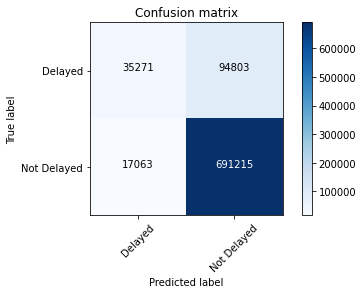

In [ ]:
y_true = testSet.select("label")
y_true = y_true.toPandas()
y_true['label'] = y_true['label'].replace([0],'Not Delayed')
y_true['label'] = y_true['label'].replace([1],'Delayed')

y_pred = testSet.select("prediction")
y_pred = y_pred.toPandas()
y_pred['prediction'] = y_pred['prediction'].replace([0],'Not Delayed')
y_pred['prediction'] = y_pred['prediction'].replace([1],'Delayed')

cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_names)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix')
plt.show()

In [ ]:
# from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
# params = ParamGridBuilder()
# params = params.addGrid(lr.regParam, [.01, .1, 1, 10]) 
#                .addGrid(lr.elasticNetParam, [0, .5, 1])
# params = params.build()
# cv = CrossValidator(estimator=pipeline,
#                     estimatorParamMaps=params,
#                     evaluator=evaluator,
#                     numFolds=5)

## Plot ROC Curve

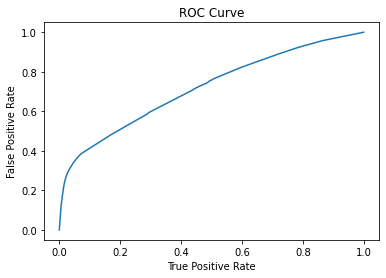

Training set areaUnderROC: 0.7170065347775996


In [ ]:
trainingSummary = rf_Model.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

## Interpreation

In [ ]:
import shap

shap_values = shap.TreeExplainer(rf_Model).shap_values(train_set)
shap.summary_plot(shap_values, train_set)

"is" with a literal. Did you mean "=="?
"is" with a literal. Did you mean "=="?
"is" with a literal. Did you mean "=="?
"is" with a literal. Did you mean "=="?
"is not" with a literal. Did you mean "!="?
"is not" with a literal. Did you mean "!="?


---------------------------------------------------------------------------
Py4JError                                 Traceback (most recent call last)
<command-2647101326227347> in <cell line: 3>()
      1 import shap
      2 
----> 3 shap_values = shap.TreeExplainer(rf_Model).shap_values(train_set)
      4 shap.summary_plot(shap_values, train_set)

/databricks/python/lib/python3.9/site-packages/shap/explainers/_tree.py in __init__(self, model, data, model_output, feature_perturbation, feature_names, approximate, **deprecated_options)
    147         self.feature_perturbation = feature_perturbation
    148         self.expected_value = None
--> 149         self.model = TreeEnsemble(model, self.data, self.data_missing, model_output)
    150         self.model_output = model_output
    151         #self.model_output = self.model.model_output # this allows the TreeEnsemble to translate model outputs types by how it loads the model

/databricks/python/lib/python3.9/site-packages/shap/expl

# MLP

## Train MLP Model

In [ ]:
paramGrid_mlp = {'maxIter': [100],
                'layers': [
                    [len(columns_categorical) + len(cont_feat),5,3,2]
                ],
                 'blockSize': [128]
                }


mlp_best_parameters, mlp_best_score = blocktimeSeriesCV(parquet_string='1',
                                                        sampling='down',
                                                      param_grid = paramGrid_mlp, 
                                                      pipeline_fn = scaled_pipeline, 
                                                      model_type='mlp', 
                                                        k=2, 
                                                        metric='f2'
                                                     )

Parameters: {'maxIter': 100, 'layers': [1, 5, 3, 2], 'blockSize': 128}
Number of validation observations for each fold is 1,868,510
************************************************************
    Number of training observations for fold number 1 is 710,012 with a f2 score of 0.08
------------------------------------------------------------
Number of validation observations for each fold is 1,868,510
************************************************************
    Number of training observations for fold number 2 is 780,616 with a f2 score of 0.11
------------------------------------------------------------
f2 was BETTER, new best score of 0.09
Training on full train dataset, and validating on dev dataset with best parameters from CV:
{'maxIter': 100, 'layers': [1, 5, 3, 2], 'blockSize': 128}


## Evaluate MLP Model

Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
 CV Result of mlp
           Train   Test
ROC AUC    0.519  0.513
F2 Score   0.097  0.076
Recall     0.080  0.065
Precision  0.651  0.256
Accuracy   0.519  0.806


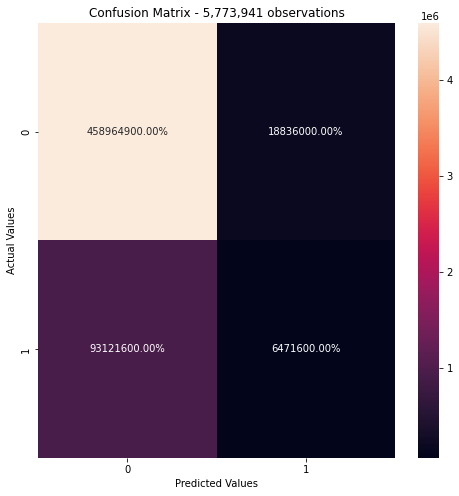

'MultilayerPerceptronClassificationModel' object has no attribute 'featureImportances'


In [ ]:
mlpModel, pred_result_mlp = validation(full_train_df, full_test_df, sampling ='down',
                                       model_type = 'mlp', 
                                       best_parameters = mlp_best_parameters, 
                                       pipeline_fn = scaled_pipeline
                                    )

In [ ]:
# # https://github.com/maxpumperla/elephas

# !pip install elephas

In [ ]:
# from pyspark import SparkContext, SparkConf
# conf = SparkConf().setAppName('Elephas_App').setMaster('local[8]')
# sc = SparkContext(conf=conf)

---------------------------------------------------------------------------
Py4JError                                 Traceback (most recent call last)
<command-942460095360587> in <cell line: 2>()
      1 from pyspark import SparkContext, SparkConf
----> 2 conf = SparkConf().setAppName('Elephas_App').setMaster('local[8]')
      3 sc = SparkContext(conf=conf)

/databricks/spark/python/pyspark/conf.py in __init__(self, loadDefaults, _jvm, _jconf)
    129             if _jvm is not None:
    130                 # JVM is created, so create self._jconf directly through JVM
--> 131                 self._jconf = _jvm.SparkConf(loadDefaults)
    132                 self._conf = None
    133             else:

/databricks/spark/python/lib/py4j-0.10.9.5-src.zip/py4j/java_gateway.py in __call__(self, *args)
   1583 
   1584         answer = self._gateway_client.send_command(command)
-> 1585         return_value = get_return_value(
   1586             answer, self._gateway_client, None, self._fqn